# Load data from Kaggle

In [ ]:
# https://stackoverflow.com/questions/49310470/using-kaggle-datasets-in-google-colab
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"suhasaithal","key":"c87c41921fe9344b9c854878138972be"}'}

In [ ]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

-rw-r--r-- 1 root root 67 Nov 24 04:47 kaggle.json


In [ ]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [ ]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download data from Kaggle using its API
!kaggle competitions download -c vsb-power-line-fault-detection

  0% 0.00/158k [00:00<?, ?B/s]
100% 158k/158k [00:00<00:00, 60.6MB/s]
100% 6.97G/6.97G [04:14<00:00, 46.7MB/s]
100% 6.97G/6.97G [04:14<00:00, 29.4MB/s]
  0% 0.00/257k [00:00<?, ?B/s]
100% 257k/257k [00:00<00:00, 82.6MB/s]
  0% 0.00/115k [00:00<?, ?B/s]
100% 115k/115k [00:00<00:00, 102MB/s]
100% 3.02G/3.02G [02:18<00:00, 18.5MB/s]
100% 3.02G/3.02G [02:18<00:00, 23.4MB/s]


In [ ]:
# https://stackoverflow.com/questions/49685924/extract-google-drive-zip-from-google-colab-notebook
# !unzip /content/train.parquet.zip
# !unzip /content/test.parquet.zip

# Load Libraries

In [ ]:
!sudo apt-get install libsnappy-dev
!pip install python-snappy
!pip install fastparquet
!pip install kneed

# https://github.com/raphaelvallat/entropy/issues/4#issue-533857629
!pip install git+https://github.com/raphaelvallat/entropy.git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  libsnappy-dev
0 upgraded, 1 newly installed, 0 to remove and 14 not upgraded.
Need to get 27.2 kB of archives.
After this operation, 108 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libsnappy-dev amd64 1.1.7-1 [27.2 kB]
Fetched 27.2 kB in 1s (36.4 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package libsnappy-dev:amd64.
(Reading database ... 144793 files and

In [ ]:
import numpy as np
import pandas as pd
import dask as dd
import pyarrow.parquet as pq
import pyarrow as pa
import os
%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from scipy.stats import norm, skew

import gc
import pywt
from statsmodels.robust import mad
import scipy
from scipy import signal
from scipy.signal import butter
from scipy.signal import find_peaks, peak_widths, peak_prominences

from datetime import datetime

from scipy.signal import periodogram
from sklearn.neighbors import KDTree

from keras.layers import *
from keras.models import *
from keras import backend as K # The backend gives us access to tensorflow operations and allow us to create attention class
from keras import optimizers # Allows to access Adam class and modify some parameters
from keras.callbacks import * # This object helps the model to train in a smarter way, avoid overfitting
from keras import activations
from keras import regularizers
from keras import initializers
from keras import constraints
from keras.utils.vis_utils import plot_model
import tensorboard
%load_ext tensorboard
import tensorflow.compat.v1 as tf

# https://stackoverflow.com/a/56569206/4699076
tf.disable_eager_execution()

from sklearn.model_selection import GridSearchCV, StratifiedKFold

import concurrent.futures
import multiprocessing
from kneed import KneeLocator
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import SGDRegressor
from IPython.display import Image
from sklearn.metrics import matthews_corrcoef
import numba
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix

import scipy.stats as stats
import pylab
from sklearn.ensemble import RandomForestClassifier
import random
import pickle
from sklearn.metrics import log_loss
from entropy import *
from prettytable import PrettyTable
import lightgbm as lgb

from sklearn.preprocessing import OneHotEncoder
from itertools import combinations

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
from google.colab import output
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/My Drive/Colab Notebooks/Assignment_29-VSB_Power_Line/'
test_path = '/content/drive/My Drive/Colab Notebooks/Assignment_29-VSB_Power_Line/test_path'

# Read Data

In [ ]:
metadata_train = pd.read_csv("/content/metadata_train.csv")
metadata_test = pd.read_csv("/content/metadata_test.csv")

# train = pd.read_parquet('/content/train.parquet', engine='fastparquet')
# test = pd.read_parquet('/content/test.parquet', engine='fastparquet')

# Featurization

## Utility Functions

**General**

In [ ]:
def parallel_proc_func(func, cols, no_signals, init_offset, 
                       save_file_path='None', *args):
  """
  Perform parallel processing of the given function. 
  If a function has to be parallelized over several items (signal_ids), then they
  can be parallelized based on the number of cores present in the CPU.
  The results are stored in a csv file.

  Parameters
  ----------
  func : function object
    The function which is to be run parallely.
  cols : numpy.ndarray
    Names of the result columns that is to be stored in the csv file
  no_signals : int
    Total number of signals to be processed
  init_offset : int
    Initial offset of the item (signal_id) from where the iterations are to begin
  save_file_path : string (Default - 'None')
    Path of the csv file where the results are to be stored.
    If None, resulting dataframe is returned.
  *args : Tuple
    Additional parameters (along with signal id) that are needed for the func 
    object.  

  Returns
  -------
  None (Default)
    If the file has to be saved, then the resultant data frame is stored in the
    respective save_file_path. Hence, nothing is returned.
  df : pandas.DataFrame
    If the file is not to be saved, then the resultant data frame is returned.
  """
  # Get number of cores in cpu: https://stackoverflow.com/a/1006337/4699076
  batch_size = multiprocessing.cpu_count() # no. of cores in the cpu, needed for parallel processing  
  end_val = no_signals//batch_size
  # Save the file after processing (save_pt*batch_size) number of signals
  save_pt = end_val//10
  if save_pt == 0:
    save_pt = 1

  # Check if file is already processed
  if os.path.isfile(save_file_path):
    df = pd.read_csv(save_file_path)
    df.drop(['Unnamed: 0'], axis=1, inplace=True)
    start_val = df.shape[0]//batch_size
    print(f"{df.shape[0]} signal ids already processed.")
    print("Processing the remaining signal ids...")    
  else:
    # If specific columns are given, then create a dataframe with the given columns
    if cols != 'None':
      df = pd.DataFrame(columns=cols)
    # Create an empty dataframe if no columns given
    else:
      df = pd.DataFrame()
    if save_file_path != 'None':
      df.to_csv(save_file_path)
    
    start_val = 0
  
  start_batch = datetime.now()
  # Begin iteration
  for i in range(start_val, end_val):
    sig_id = np.arange(init_offset+(i*batch_size),
                        init_offset+(i*batch_size)+batch_size)
    # If additional arguments are provided for 'func' object, 
    # then create a list containing signal ids and new argument
    if len(args) != 0:
      func_args = [(x, args[0]) for x in sig_id]
    # If new arguments are not provided, then create a list of signal ids
    else:
      func_args = sig_id
    
    # Begin parallel processing
    with concurrent.futures.ProcessPoolExecutor() as executor:
      results = executor.map(func, func_args)
      for result in results:
        # For dataframe with pre-defined columns
        if cols != 'None':
          temp_df = pd.DataFrame(data=[result], columns=cols)
        # For dataframes with no pre-defined columns
        else:
          temp_df = pd.DataFrame(data=[result])
        df = df.append(temp_df, ignore_index=True)

    # Save file at the checkpoint
    if ((i+1)%save_pt==0):
      # Calculate and print the number of signals processed
      no_sigs_processed = (i+1)*batch_size
      print(f"{no_sigs_processed} ({np.round(((no_sigs_processed)/no_signals)*100, 2)}%) signals completed. Time taken: {datetime.now() - start_batch}")
      if save_file_path != 'None':
        df.to_csv(save_file_path)
      start_batch = datetime.now()

  # If all the signals are already processed, then start_val will be equal to end_val. 
  if start_val != end_val:
    no_signals_remaining = no_signals%batch_size
    if no_signals_remaining!=0:
      sig_id = np.arange(init_offset+(end_val*batch_size),
                        init_offset+(end_val*batch_size)+no_signals_remaining)
      if len(args) != 0:
        func_args = [(x, args[0]) for x in sig_id]
      else:
        func_args = sig_id

      # Parallel processing
      with concurrent.futures.ProcessPoolExecutor() as executor:
        results = executor.map(func, func_args)
        for result in results:
          if cols != 'None':
            temp_df = pd.DataFrame(data=[result], columns=cols)
          else:
            temp_df = pd.DataFrame(data=[result])
          df = df.append(temp_df, ignore_index=True)

  no_sigs_processed = no_signals
  print(f"{no_sigs_processed} ({np.round(((no_sigs_processed)/no_signals)*100, 2)}%) signals completed. Time taken: {datetime.now() - start_batch}")
  if save_file_path != 'None':
    df.to_csv(save_file_path)
  if save_file_path == 'None':
    return df

**Plots**

In [ ]:
def get_knee(sorted_arr_len, vals_sorted, sensitivity, curve, direction):
  # https://github.com/arvkevi/kneed
  kneedle = KneeLocator(np.arange(len(vals_sorted)), vals_sorted, S=sensitivity, 
                        curve=curve, direction='increasing')
  knee = kneedle.knee_y
  knee_ind = kneedle.knee
  return knee, knee_ind  

def plot_knee(feat_name, vals_sorted, target_marker, knee, knee_ind, compare):
  """
  Plot the knee plot of the signal.

  Parameters
  ----------
  feat_name : string
    Name of the feature which is to be plotted.
    This is used for labelling the plot.
  vals_sorted : numpy.ndarray
    The x values of the plot.
  target_marker : numpy.ndarray
    Get the indices where the respective signal has target=1
  knee : numpy.float64
    The knee value of the series.
  knee_ind : int
    Index in the series where the knee value is obtained.
  compare : boolean
    If True the plot is displayed in the subplot. 
    If False then the entire space is used for the plot.
  
  Returns
  -------
  None : Function does not return any value
  """
  if not compare:
    plt.figure(figsize=(20,5))
  x_vals = np.arange(len(vals_sorted))  
  plt.plot(x_vals, vals_sorted, label='target=1', marker='s', markevery=target_marker)
  plt.plot(x_vals, vals_sorted, label='target=0')
  plt.vlines(knee_ind, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', label='Knee Value ({})'.format(knee))
  plt.legend()
  plt.xlabel('Signal Number')
  plt.ylabel(feat_name)
  if compare:
    plt.suptitle('{} Knee Plot - All Phases'.format(feat_name))
  else:
    plt.title('{} Knee Plot - All Phases'.format(feat_name))
    plt.show()
    print('='*100)

def plot_vs_sigid(temp_metadata, feat_name, target_index, knee, compare):
  """
  Plot the feature value of the signal with respect to its signal id.

  Parameters
  ----------
  temp_metadata : pandas.DataFrame
    Dataframe containing information of the features along with measurement id
    and target information for that measurement id.
  feat_name : string
    Name of the feature that is to be plotted.
  target_index : numpy.ndarray
    Index value where that respective measurement id has target=1
  knee : numpy.float64
    Knee value for that feature.
  compare : boolean
    If True the plot is displayed in the subplot. 
    If False then the entire space is used for the plot.

  Returns
  -------
  None : Function does not return any value  
  """
  x_vals = np.arange(temp_metadata.shape[0])
  if not compare:
    plt.figure(figsize=(25,10))
  plt.plot(x_vals, temp_metadata[feat_name].values, label='target=0')
  # https://stackoverflow.com/questions/21285885/remove-line-through-marker-in-matplotlib-legend
  plt.plot(x_vals, temp_metadata[feat_name].values, marker='s', markerfacecolor='red', 
          markevery=list(target_index), label='target=1', linestyle='None')
  plt.hlines(knee, plt.xlim()[0], plt.xlim()[1], linestyles='dashed', label='Knee Value ({})'.format(knee))
  plt.legend()
  plt.xlabel('Signal ID')
  plt.ylabel(feat_name)
  if compare:
    plt.suptitle('{} Vs. Signal ID'.format(feat_name))    
  else:    
    plt.title('{} Vs. Signal ID'.format(feat_name))
    plt.show()
    print('='*100)    

def plot_pdf(temp_metadata, feat_name, knee, compare):
  """
  Plot the Probability Density Function for the given feature.

  Parameters
  ----------
  temp_metadata : pandas.DataFrame
    Dataframe containing information of the features along with measurement id
    and target information for that measurement id.
  feat_name : string
    Name of the feature that is to be plotted.
  knee : numpy.float64
    Knee value for that feature.
  compare : boolean
    If True the plot is displayed in the subplot. 
    If False then the entire space is used for the plot.

  Returns
  -------
  None : Function does not return any value
  """
  target = temp_metadata[temp_metadata['target']==1][feat_name].values
  no_target = temp_metadata[temp_metadata['target']==0][feat_name].values

  if not compare:
    print("Mean of all {} values: {}".format(feat_name, np.mean(temp_metadata[feat_name].values)))
    print("Mean of {} with target=1: {}".format(feat_name, np.mean(target)))
    print("Mean of {} with target=0: {}".format(feat_name, np.mean(no_target)))  
    plt.figure(figsize=(15,5))

  ax1 = sns.distplot(temp_metadata[feat_name].values, kde=True, hist=False, label='combined')
  ax2 = sns.distplot(target, kde=True, hist=False, label='target=1')
  ax3 = sns.distplot(no_target, kde=True, hist=False, label='target=0', )

  ax1.axvline(np.mean(temp_metadata[feat_name].values), color='blue')
  ax2.axvline(np.mean(target), color='green')
  ax3.axvline(np.mean(no_target), color='red')

  plt.vlines(knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', label='Knee Value ({})'.format(knee))
  plt.legend()
  plt.xlabel(feat_name)
  plt.ylabel('PDF')
  if compare:
    plt.suptitle('PDF of {}'.format(feat_name))
  else:
    plt.title('PDF of {}'.format(feat_name))
    plt.show()
    print('='*100)

def plot_cdf(feat_name, vals_sorted, knee, compare):
  """
  Plot the Cumulative Density Function of the given feature.

  Parameters
  ----------
  feat_name : string
    Name of the feature that is to be plotted.
  vals_sorted : numpy.ndarray
    x values of the plot.
  knee : numpy.float64
    Knee value for that feature.
  compare : boolean
    If True the plot is displayed in the subplot. 
    If False then the entire space is used for the plot.

  Returns
  -------
  None : Function does not return any value
  """
  knee_perc = (((np.where(vals_sorted==knee)[0][0])/len(vals_sorted))*100)
  percentile_vals = []
  perc = 0
  for ind, val in enumerate(vals_sorted):
    if ind==int(perc*len(vals_sorted)):
      percentile_vals.append(val)      
      perc += 0.01
  percentile_vals.append(vals_sorted[-1])
  y_vals = np.linspace(0, 1, 101)

  if not compare:
    plt.figure(figsize=(15,5))
  plt.plot(percentile_vals, y_vals)
  plt.vlines(knee, plt.ylim()[0], plt.ylim()[1], linestyle='dashed', label='Knee Value ({})'.format(knee))
  plt.hlines((knee_perc/100), plt.xlim()[0], plt.xlim()[1], linestyles='dashdot', label='Knee Value Percentile ({}%)'.format(np.round(knee_perc,2)))
  plt.legend(loc='lower right')
  plt.xlabel(feat_name)
  plt.ylabel('CDF')
  if compare:
    plt.suptitle('CDF of {}'.format(feat_name))
  else:
    plt.title('CDF of {}'.format(feat_name))
    plt.show()
    print('='*100)

def plot_box(temp_metadata, feat_name, vals_sorted, knee, compare):
  """
  Plot the box plot for the given feature.

  Parameters
  ----------
  temp_metadata : pandas.DataFrame
    Dataframe containing information of the features along with measurement id
    and target information for that measurement id.  
  feat_name : string
    Name of the feature that is to be plotted.
  vals_sorted : numpy.ndarray
    x values of the plot.
  knee : numpy.float64
    Knee value for that feature.
  compare : boolean
    If True the plot is displayed in the subplot. 
    If False then the entire space is used for the plot.

  Returns
  -------
  None : Function does not return any value
  """
  knee_perc = (((np.where(vals_sorted==knee)[0][0])/len(vals_sorted))*100)
  sns.boxplot(x=temp_metadata['target'], y=temp_metadata[feat_name])
  plt.hlines(knee, plt.xlim()[0], plt.xlim()[1], linestyles='dashed', label='Knee Value Percentile ({}%)'.format(np.round(knee_perc,2)))
  plt.legend()
  if compare:
    plt.suptitle('Box plot of signals with target=0 and target=1')
  else:
    plt.title('Box plot of signals with target=0 and target=1')
    plt.show()  
    print('='*100)

def logistic_plot(temp_metadata, feat_name, compare):
  """
  Plot logistic plot for the given feature.

  Parameters
  ----------
  temp_metadata : pandas.DataFrame
    Dataframe containing information of the features along with measurement id
    and target information for that measurement id.  
  feat_name : string
    Name of the feature that is to be plotted.  
  compare : boolean
    If True the plot is displayed in the subplot. 
    If False then the entire space is used for the plot.

  Returns
  -------
  None : Function does not return any value

  References
  ----------
  .. [1] https://www.kaggle.com/mark4h/vsb-1st-place-solution
  """
  sns.set_context("paper", font_scale=2)
  # fig, ax = plt.subplots(1, 1, figsize=(8, 6))
  sns.regplot(feat_name, 'target', temp_metadata, logistic=True, 
              n_boot=100, y_jitter=.1, 
              scatter_kws={'alpha':0.1, 'edgecolor':'none'})
  if compare:
    plt.suptitle('Logistic plot of signals with target=0 and target=1')
  else:
    plt.title('Logistic plot of signals with target=0 and target=1')
    plt.show()
    print('='*100)

In [ ]:
def feature_eda(temp_metadata, feat_name, plot_name, phase, compare, 
                sensitivity=1, curve='convex'):
  """
  Performs Exploratory Data Analysis for the given feature.

  Following information is displayed upon calling this function:
  * Knee plot
  * Feature value vs. signal id
  * PDF
  * CDF
  * Box plot
  * Logistic plot
  * Statistics

  Parameters
  ----------
  temp_metadata : pandas.DataFrame
    Dataframe containing information of the features along with measurement id
    and target information for that measurement id.  
  feat_name : string
    Name of the feature that is to be plotted.
  plot_name : string
    Name of the plot that is to be displayed.
    Following are the valid strings for the plot:
    * 'knee' - to display only knee plot
    * 'sigid' - to display only feature vs. signal id plot
    * 'pdf' - to display only the pdf plot
    * 'cdf' - to display only the cdf plot
    * 'box' - to display only the box plot
    * 'stats' - to display only statisticss
    * 'all' - to display all the plots and statistics
  phase : string
    This is to process the features with respect to signal id or with respect
    to measurement id.
    Following are valid strings:
    * 'one_phase' - when feature is calculated for each signal id
    * 'multi_phase' - when 3 phases of the signal is combined and processed
  compare : boolean
    If True plots are displayed in a subplot for comparing the two plots.
    If False then the entire space is used to display the plot.
  sensitivity : float (Default=1)
    This value adjusts the position where the knee value is to be detected.
  curve : string (Default='convex')
    How the values sorted in the ascending order look like.
    If 'convex' - sorted values look like exp(x) curve
    If 'concave' - sorted values look like sigmoid(x) curve
    
  Returns
  -------
  None : Function does not return any value
  """
  # Get the indices where the target is 1
  if phase=='one_phase':
    target_index = temp_metadata[temp_metadata['target']==1]['signal_id'].values
  elif phase=='multi_phase':
    target_index = temp_metadata[temp_metadata['target']==1]['id_measurement'].values

  # Sort the feature values in ascending order
  vals_sorted = np.sort(temp_metadata[feat_name].values)

  # Get the original indices of the sorted feature values
  vals_ind = np.argsort(temp_metadata[feat_name].values)

  # Get the original indices of the sorted feature values where target is 1
  target_marker = []
  for ind, val in enumerate(target_index):
    target_marker.append(np.where(vals_ind==val)[0][0])

  # https://github.com/arvkevi/kneed
  kneedle = KneeLocator(np.arange(len(vals_sorted)), vals_sorted, S=sensitivity, 
                        curve=curve, direction='increasing')
  knee = kneedle.knee_y
  knee_ind = kneedle.knee

  # If plot_name = 'all', then plot all the graphs
  # Else plot the respective graphs
  # Plot knee plot
  if (plot_name=='all') | (plot_name=='knee'):
    plot_knee(feat_name, vals_sorted, target_marker, knee, knee_ind, compare)
  
  if (plot_name=='all') & (not compare):
    print("The knee value of the {} is: {}".format(feat_name, knee))
    print(f"Number of signals with {feat_name} greater than {knee} and target=1: {len(np.where(np.array(target_marker) > knee_ind)[0])}({np.round((len(np.where(np.array(target_marker) > knee_ind)[0]) / temp_metadata.shape[0])*100 , 2)}%)")
    print(f"Number of signals with {feat_name} greater than {knee} and target=0: {len(np.where(vals_sorted > knee)[0])}({np.round((len(np.where(vals_sorted > knee)[0]) / temp_metadata.shape[0])*100 , 2)}%)")
    print("Number of signals with target=1: {}".format(len(target_index)))

  # Plot feature values vs signal id
  if (plot_name=='all') | (plot_name=='sigid'):
    plot_vs_sigid(temp_metadata, feat_name, target_index, knee, compare)

  # Plot PDF
  if (plot_name=='all') | (plot_name=='pdf'):
    plot_pdf(temp_metadata, feat_name, knee, compare)

  # Plot CDF
  if (plot_name=='all') | (plot_name=='cdf'):
    plot_cdf(feat_name, vals_sorted, knee, compare)

  # Plot box plot
  if (plot_name=='all') | (plot_name=='box'):
    plot_box(temp_metadata, feat_name, vals_sorted, knee, compare)
  
  # Plot logistic plot
  if (plot_name=='all') | (plot_name=='logistic'):
    logistic_plot(temp_metadata, feat_name, compare)
  
  # Print statistics
  if ((plot_name=='all') | (plot_name=='stats')) & (not compare):
    # https://stackoverflow.com/questions/34816769/getting-values-in-seaborn-boxplot
    stats = temp_metadata[feat_name].describe()
    print(f"Statistics of all signals:\n{stats}")    
    print(f"Inter Quartile Range of all Signals: {stats[6]-stats[4]}\n")

    stats = temp_metadata.groupby('target')[feat_name].describe().iloc[0]    
    print(f"Statistics of signals with target=0:\n{stats}")
    print(f"Inter Quartile Range of all signals with target=0: {stats[6]-stats[4]}\n")

    stats = temp_metadata.groupby('target')[feat_name].describe().iloc[1]
    print(f"Statistics of signals with target=1:\n{stats}")
    print(f"Inter Quartile Range of all signals with target=1: {stats[6]-stats[4]}\n")

def pca_plots(threshold_pos, threshold_neg, all_feats_df, cols, labels):
  """
  Plots PCA plot for the given data.

  Parameters
  ----------
  threshold_pos : float
    Positive threshold value for the mean correlation value for each feature.
    It will select only those features whose mean correlation value is less than
    this value.
  threshold_neg : float
    Negative threshold value for the mean correlation value for each feature.
    It will select only those features whose mean correlation value is greater 
    than this value.
  all_feats_df : pandas.DataFrame
    Dataframe containing all the feature values. 
    These feature values are not standardized.
  cols : list
    List of names of all the features.    

  Returns
  -------
  pca_df : pandas.DataFrame
    Dataframe comprising the reduced dimension.
  pca_cols : list
    List of strings specifying the selected columns for the given thresholds.
  pca.explained_variance_ : numpy.array
    Explained variance values (lambda) corresponding to each principal
    component.
  """  
  pca_cols = []
  # Select the features whose mean correlation value lies between positive and 
  # negative threshold values
  for ind, col in enumerate(cols):
    if mean_corr[ind] < threshold_pos and mean_corr[ind] > threshold_neg:
      pca_cols.append(col)
  # Standardize the features
  std = StandardScaler()
  s = std.fit_transform(all_feats_df[pca_cols])

  # Get all the principal components
  pca = PCA()
  pca_s = pca.fit_transform(s)
  pca_df = pd.DataFrame(pca_s[:,0:2], columns=['1st_principal', '2nd_principal'])
  pca_df['label'] = labels  
  return pca_df, pca_cols, pca.explained_variance_

def tsne_plots(threshold_pos, threshold_neg, all_feats_df, cols, labels, perp, iter):
  """
  Plots TSNE plot for the given data.

  Parameters
  ----------
  threshold_pos : float
    Positive threshold value for the mean correlation value for each feature.
    It will select only those features whose mean correlation value is less than
    this value.
  threshold_neg : float
    Negative threshold value for the mean correlation value for each feature.
    It will select only those features whose mean correlation value is greater 
    than this value.
  all_feats_df : pandas.DataFrame
    Dataframe containing all the feature values. 
    These feature values are not standardized.
  cols : list
    List of names of all the features.        
  perp : int
    Specify the required perplexity in the TSNE plot.
  iter : int
    Specify the number of iterations to run for the TSNE plot.

  Returns
  -------
  tsne_df : pandas.DataFrame
    Dataframe comprising the reduced dimension.    
  """
  tsne_cols = []
  # Select the features whose mean correlation value lies between positive and 
  # negative threshold values
  for ind, col in enumerate(cols):
    if mean_corr[ind] < threshold_pos and mean_corr[ind] > threshold_neg:
      tsne_cols.append(col)
  # Standardize the features
  std = StandardScaler()
  s = std.fit_transform(all_feats_df[tsne_cols])
  tsne = TSNE(n_components=2, perplexity=perp, n_iter=iter, random_state=42)
  tsne_s = tsne.fit_transform(s)
  tsne_df = pd.DataFrame(tsne_s, columns=['Dim_1','Dim_2'])
  tsne_df['label'] = labels
  return tsne_df  


In [ ]:
plt_list = ['knee', 'sigid', 'pdf', 'cdf', 'box', 'logistic']
title_names = ['Original', 'Outlier processed']

def plot_compare(feat_name, phase, plt_list=plt_list, title_names=title_names, *args):
  """
  Display the plots side by side for comparison.

  Parameters
  ----------
  feat_name : string
    Name of the feature to be compared in the Dataframe 1.
  plt_list : list
    Names of the plots to be displayed
  original_df : pandas.DataFrame
    Dataframe 1 to be compared.
  denoised_df : pandas.DataFrame
    Dataframe 2 to be compared.
  phase : string
    This is to process the features with respect to signal id or with respect
    to measurement id.
    Following are valid strings:
    * 'one_phase' - when feature is calculated for each signal id
    * 'multi_phase' - when 3 phases of the signal is combined and processed

  Returns
  -------
  None : Function does not return any value
  """
  no_plts = len(plt_list)
  no_compares = len(args[0])  
  for ind, plt_name in enumerate(plt_list):    
    for args_val in args:
      plt.figure(figsize=(100,25))
      count = 0
      for df_ind, df in enumerate(args_val):
        count += 1               
        # plt.subplot(no_plts,no_compares,count)
        plt.subplot(1,no_compares,count)
        feature_eda(df, feat_name, plt_name, phase, True, 1)
        plt.title(title_names[df_ind])
      plt.show()
      print('='*150)

def plot_multi_compare(feat_list, phase, plt_list, df):
  """
  Display multiple plots side by side for comparison. 
  Here the comparison is among different features of the single dataframe.

  Parameters
  ----------
  feat_list : list
    List of names of the features to be compared in the Dataframe df.
  phase : string
    This is to process the features with respect to signal id or with respect
    to measurement id.
    Following are valid strings:
    * 'one_phase' - when feature is calculated for each signal id
    * 'multi_phase' - when 3 phases of the signal is combined and processed    
  plt_list : list
    Names of the plots to be displayed
  df : pandas.DataFrame
    Dataframe containing the features to be compared.

  Returns
  -------
  None : Function does not return any value
  """  
  no_plts = len(plt_list)
  no_compares = len(feat_list)    
  for ind, plt_name in enumerate(plt_list):
    plt.figure(figsize=(100,25))
    count = 0
    for feat_ind, feat_name in enumerate(feat_list):
      count += 1
      plt.subplot(1, no_compares, count)
      feature_eda(df, feat_name, plt_name, phase, True)
      plt.title(feat_name)
    plt.show()
    print('='*150)

def plot_multi_compare_1(feat_list, phase, plt_list, df):
  """
  Display multiple plots side by side for comparison.
  Here the comparison is among different features of the single dataframe. 
  This differs from plot_multi_compare in the number of plot that are compared.

  Parameters
  ----------
  feat_list : list
    List of names of the features to be compared in the Dataframe df.
  phase : string
    This is to process the features with respect to signal id or with respect
    to measurement id.
    Following are valid strings:
    * 'one_phase' - when feature is calculated for each signal id
    * 'multi_phase' - when 3 phases of the signal is combined and processed    
  plt_list : list
    Names of the plots to be displayed
  df : pandas.DataFrame
    Dataframe containing the features to be compared.

  Returns
  -------
  None : Function does not return any value
  """    
  no_plts = len(plt_list)
  no_cols = 3
  no_rows = np.ceil(len(feat_list)/no_cols)
  
  for ind, plt_name in enumerate(plt_list):
    # plt.figure(figsize=(no_rows*row_size,no_cols*col_size))
    plt.figure(figsize=(50,50))
    count = 0
    for feat_ind, feat_name in enumerate(feat_list):
      count += 1
      plt.subplot(no_rows, no_cols, count)
      feature_eda(df, feat_name, plt_name, phase, True)
      plt.title(feat_name)
    plt.show()
    print('='*150)

**Discrete Wavelet Transform**

In [ ]:
def dwt(x):
  """
  Apply DWT and Highpass filter on the signal. 
  Raw signal is first read, low frequency signals are removed and denoising is 
  done by DWT.
  Butterworth high pass digital filter is used to remove low frequency signals.

  Parameters
  ----------
  x : numpy.ndarray
    Raw signal.
  
  Returns
  -------
  x : numpy.ndarray
    Denoised signal.

  References
  ----------
  .. [1] https://www.kaggle.com/jackvial/dwt-signal-denoising
  .. [2] http://connor-johnson.com/2016/01/24/using-pywavelets-to-remove-high-frequency-noise/
  .. [3] Threshold equation and using hard mode in threshold as mentioned
         in section '3.2 denoising based on optimized singular values' from paper by Tomas Vantuch:
         http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf  
  .. [4] https://www.dropbox.com/s/2ltuvpw1b1ms2uu/A%20Complex%20Classification%20Approach%20of%20Partial%20Discharges%20from%20Covered%20Conductors%20in%20Real%20Environment%20%28preprint%29.pdf?dl=0
  """      
  # Decompose to get the wavelet coefficients
  # 'db4' wavelet is used because of the expert setting mentioned in the References [4]
  # 'per' refers to periodic-padding, as the raw signal is a periodic one  
  wavlt_coeffs = pywt.wavedec(x, 'db4', mode="per")
  
  # Only the 1st level detailed coefficients are used to perform the thresholding and 
  # the 1s level approximate coefficients which contain low frequency compoenents (sine wave) are not used.
  # Calculation of sigma value to perform threholding, is also as per References [3]
  sigma = (1/0.6745) * np.mean(np.absolute(wavlt_coeffs[-1] - np.mean(wavlt_coeffs[-1],None)), None)
  # Calculate the universal threshold using Stein Unbiased Risk Estimate (SURE), as per References [3]
  Td = sigma * np.sqrt(2*np.log(len(x)))
  # The calculated threshold value is used to perform 'hard-thresholding' on all the 
  # other detailed coefficient values.
  wavlt_coeffs[1:] = (pywt.threshold(i, value=Td, mode='hard') for i in wavlt_coeffs[1:])

  # Reconstruct the signal using the thresholded coefficients
  x_dn = pywt.waverec(wavlt_coeffs, 'db4', mode='per')

  # Remove signals whose frequency is below 10KHz (References [4]) as the PD pattern 
  # is found mostly above 10KHz
  # Determine the cutoff frequency based on Nyquist criteria
  sample_rate = len(x)/0.02
  nyquist_rate = 0.5 * sample_rate
  cut_off = 1e4/nyquist_rate

  # Get the digital filter coefficients
  # Order=10 referring to the 'strictness' of the cutoff
  # Wn refers to the cutoff frequency value
  # btype refers to the type of filter to be used
  # output='sos' refers to second-order sections representations of IIR filter
  filter_coeffs = butter(10, Wn=[cut_off], btype='highpass', output='sos')
  # Apply the high pass filter on the DWT denoised signal
  x_dn_hp = signal.sosfilt(filter_coeffs, x_dn)

  return x_dn_hp

**Phase resolve features**

In [ ]:
def phase_resolve(args):
  """
  Get the number of false, positive, and negative peaks present in each 
  location (I, II, III, IV quadrants) of the signal.

  Following procedure is used:
  *  Get the indices of true, false, symmetric, positive, negative peaks of the signal.
  *  Get the phase angle of the raw signal.
  *  Get the location of all the peaks for a 0 degree phase angled signal.
  *  Add the phase angle of the signal to the location of the peak.
  *  Aggregate the number of peaks in each quadrant.

  Note:
  Quadrants - 
  * I: 0 degree - 90 degree
  * II: 90 degree - 180 degree
  * III: 180 degree - 270 degree
  * IV: 270 degree - 360 degree

  Parameters
  ----------
  args : Tuple
    Tuple containing the following:
    * sig_id
    * sig_type - 'train' or 'test'
    * phase_cols - names of the required features
    * peak_val - minimum threshold value to consider a peak

  Returns
  -------
  phase_df : numpy.ndarray
    Following features are returned:
    * t_q0 - number of true peaks in I quadrant
    * t_q1 - number of true peaks in II quadrant
    * t_q2 - number of true peaks in III quadrant
    * t_q3 - number of true peaks in IV quadrant
    * f_q0 - number of false peaks in I quadrant
    * f_q1 - number of false peaks in II quadrant
    * f_q2 - number of false peaks in III quadrant
    * f_q3 - number of false peaks in IV quadrant
    * p_q0 - number of postive peaks in I quadrant
    * p_q1 - number of postive peaks in II quadrant
    * p_q2 - number of postive peaks in III quadrant
    * p_q3 - number of postive peaks in IV quadrant
    * n_q0 - number of negative peaks in I quadrant
    * n_q1 - number of negative peaks in II quadrant
    * n_q2 - number of negative peaks in III quadrant
    * n_q3 - number of negative peaks in IV quadrant    
  """
  sig_id = str(args[0])
  sig_type = args[1][0]
  phase_cols = args[1][1]
  peak_val = args[1][2]

  if sig_type == 'train':
    x = pd.read_parquet(path + 'train.parquet', engine='fastparquet', columns=[sig_id])
    x = x.values.flatten()
  elif sig_type == 'test':
    x = pd.read_parquet(path + 'test.parquet', engine='fastparquet', columns=[sig_id])
    x = x.values.flatten()

  x_dn = dwt(x)
  t, f, s, p, n = get_all_peaks(x_dn, peak_val)

  num_val = x.shape[0]
  # Takes cosine wave as reference.
  # 0 deg => 0 deg of cosine wave,
  # 90 deg => 90 deg phase shift of cosine wave
  omegas = np.exp(-2j * np.pi * np.arange(num_val) / num_val)
  sig_phase = omegas.dot(x)
  sig_phase_angle = np.angle(sig_phase, deg=False)

  dt = (20e-3/(800000))
  f1 = 50
  w1 = 2*np.pi*f1

  phase_df = pd.DataFrame(columns=phase_cols)
  phases = [0, 1, 2, 3]
  count = 0
  for peak_inds in [t, f, p, n]:
    peak_phase_angle_arr = []
    for ind in peak_inds:
      peak_phase_angle_arr.append((np.degrees((w1* ind *dt) + sig_phase_angle)) % 360)
    
    temp_df = pd.DataFrame(data=peak_phase_angle_arr, columns=['peak_arr'])
    temp_df['quadrant'] = pd.cut(x=peak_phase_angle_arr,
                                 bins=[0, 90, 180, 270, 360],
                                 labels=phases)
    phase_bins = temp_df['quadrant'].value_counts()
    for phase in phases:
      phase_df[phase_df.columns[count]] = phase_bins[phase_bins.index==phase].values
      count += 1
  
  return phase_df.values[0]

**Fractal features**

In [ ]:
def get_fractal(fract_params):
  """
  Calculate the given fractal features.
  Following fractal features are calculated:
  1. Petrosian fractal
  2. Katz fractal
  3. Detrended Fluctuation Analysis (DFA) fractal
  4. Higuchi fractal

  Parameters
  ----------
  fract_params : list
    List of function objects which are used to calculate the above 
    mentioned fractals.
  
  Returns
  -------
  temp_fd : list
    List of above mentioned fractal values.

  References
  ----------
  .. [1] https://hal.inria.fr/inria-00442374/document
  .. [2] https://raphaelvallat.com/entropy/build/html/_modules/entropy/fractal.html#petrosian_fd
  .. [3] http://tux.uis.edu.co/geofractales/articulosinteres/PDF/waveform.pdf  
  .. [4] https://youtu.be/gB9n2gHsHN4
  .. [5] https://www.youtube.com/watch?v=o0LndP2OlUI
  .. [6] https://cschoel.github.io/nolds/nolds.html#detrended-fluctuation-analysis
  .. [7] https://www.kaggle.com/tarunpaparaju/vsb-competition-attention-bilstm-with-features
  .. [8] https://arxiv.org/ftp/arxiv/papers/0707/0707.1437.pdf
  .. [9] https://www.sciencedirect.com/science/article/pii/S2212017313006506
  .. [10] https://arxiv.org/pdf/cond-mat/0103510.pdf
  """
  sig_id = str(fract_params[0])
  sig_type = fract_params[1][0]
  sig_type_1 = fract_params[1][1]
  window_size = fract_params[1][2]
  fract_fun = fract_params[1][3]

  if sig_type_1 == 'test':
      sig_data = pd.read_parquet(path + 'test.parquet', engine='fastparquet', columns=[sig_id])
      sig_data = sig_data.values.flatten()
  elif sig_type_1 == 'train':
      sig_data = pd.read_parquet(path + 'train.parquet', engine='fastparquet', columns=[sig_id])
      sig_data = sig_data.values.flatten()
    
  if sig_type == 'denoised':
    sig_data = dwt(sig_data)
  
  no_winds = sig_data.shape[0]//window_size
  rem_winds = sig_data.shape[0]%window_size
  temp_fd = []

  for func in fract_fun:
    avg_fd = 0
    for wind in range(no_winds):
      avg_fd += func(sig_data[wind*window_size:(wind*window_size)+window_size])
    if rem_winds != 0:
      avg_fd += func(sig_data[(wind*window_size)+window_size:sig_data.shape[1]])
    avg_fd /= no_winds
    temp_fd.append(avg_fd)

  return temp_fd

**Entropy features**

In [ ]:
def get_entropy(entropy_params):
  """
  Calculate the given entropy features:
  Following entropy features are calculated:
  1. Permutation entropy
  2. SVD entropy

  Parameters
  ----------
  entropy_params : list
    List of function objects which are used to calculate the above 
    mentioned entropy features.  

  Returns
  -------
  temp_fd : list
    List of above mentioned entropy values.

  References
  ----------
  .. [1] https://www.mdpi.com/1099-4300/14/8/1553/htm
  .. [2] https://core.ac.uk/download/pdf/25794249.pdf
  .. [3] https://in.mathworks.com/help/signal/ref/pentropy.html#mw_a57f549d-996c-47d9-8d45-e80cb739ed41
  .. [4] https://math.stackexchange.com/questions/542035/what-does-svd-entropy-capture
  .. [5] https://raphaelvallat.com/entropy/build/html/generated/entropy.svd_entropy.html
  .. [6] https://www.kaggle.com/tarunpaparaju/vsb-competition-attention-bilstm-with-features
  .. [7] https://www.aptech.com/blog/permutation-entropy/
  .. [8] https://www.hindawi.com/journals/complexity/2019/1403829/
  .. [9] https://www.sciencedirect.com/science/article/abs/pii/S0888327011005140
  .. [10] https://pdfs.semanticscholar.org/b769/8638ef9a9fa72c106f4c9829540c14070255.pdf?_ga=2.12379831.2082352284.1586606415-399075921.1580401470
  """
  sig_id = str(entropy_params[0])
  sig_type = entropy_params[1][0]
  sig_type_1 = entropy_params[1][1]
  window_size = entropy_params[1][2]
  entropy_fun = entropy_params[1][3]
  func_params = entropy_params[1][4]
    
  if sig_type_1 == 'train':
    sig_data = pd.read_parquet(path + 'train.parquet', engine='fastparquet', columns=[sig_id])
    sig_data = sig_data.values.flatten()
  elif sig_type_1 == 'test':
    sig_data = pd.read_parquet(path + 'test.parquet', engine='fastparquet', columns=[sig_id])
    sig_data = sig_data.values.flatten()
    
  if sig_type == 'denoised':
    sig_data = dwt(sig_data)

  no_winds = sig_data.shape[0]//window_size
  rem_winds = sig_data.shape[0]%window_size
  

  temp_ent = []

  for func_ind, func in enumerate(entropy_fun):
    avg_ent = 0
    for wind in range(no_winds):
      if func_ind not in func_params.keys():
        avg_ent += func(sig_data[wind*window_size:(wind*window_size)+window_size])
      else:
        avg_ent += func(sig_data[wind*window_size:(wind*window_size)+window_size], int(func_params[func_ind]))
    if rem_winds != 0:
      if func_ind not in func_params.keys():
        avg_fd += func(sig_data[(wind*window_size)+window_size:sig_data.shape[1]])
      else:
        avg_fd += func(sig_data[(wind*window_size)+window_size:sig_data.shape[1]], int(func_params[func_ind]))
    avg_ent /= no_winds
    temp_ent.append(avg_ent)

  return temp_ent

**Cluster features**

In [ ]:
def get_peak_index(func_params):
  """
  Get the indices of all the 'true peaks' of the a signal.

  Parameters
  ----------
  func_params : list
    Contains the following parameters:
    * signal id - func_params[0]
      Id of the signal that is to be processed
    * signal type - func_params[1]
      Type (train or test) of signal to be processed.

  Returns
  -------
  t : numpy.ndarray
    True peak indices of the signal.
  """
  sig_id = func_params[0]
  sig_type = func_params[1]
  if sig_type == 'train':
    x = pd.read_parquet(path + 'train.parquet', engine='fastparquet', columns=[str(sig_id)])
  else:
    x = pd.read_parquet(path + 'test.parquet', engine='fastparquet', columns=[str(sig_id)])
  x = dwt(x.values.flatten())
  peak_thresh = np.load(path + 'best_peak_threshold.npy')
  t, _, _, _, _ = get_all_peaks(x, int(peak_thresh))
  return t

def get_clusters(args):
  """
  Assign a cluster value for all the true peak indices that are close to each other.
  Two peak indices are considered to be from the same cluster if the distance
  between them is less than the given threshold.

  Clustering process example:
  Let t_ind_1 and t_ind_2 be two true peak index values of a signal.
  Let perc be the minimum difference needed between consecutive indices to be
  part of the same cluster.
  Step 1: Assign a value to t_ind_1, say 0 i.e., t_ind_1_cluster = 0
  Step 2: Get the difference between t_ind_1 and t_ind_2 i.e., 
          t_ind_diff = (t_ind_2 - t_ind_1)
  Step 3: If difference is less than threshold, then make t_ind_2 part of the 
          same cluster as t_ind_1, i.e., t_ind_2_cluster = 0
          If difference is greater than threshold, then make t_ind_2 part of a
          differenct cluster as t_ind_1, i.e., t_ind_2_cluster = 1
  Repeat the process for all the indices.

  Parameters
  ----------
  args : list
    Following parameters are passed:
    * signal id : string
      Id of the signal whose clustering has to be done
    * perc : int
      The threshold value which gives the minimum distance the consecutive peak
      indices should have to be considered as part of the same cluster.

  Returns
  -------
  cluster_arr : numpy.ndarray
    Array containing the cluster values for each true index.
  """
  sig_id = int(args[0])
  perc = args[1]  

  peak_inds = peak_cluster_df.iloc[sig_id].dropna()
  num_peak_inds = len(peak_inds)
  if num_peak_inds <= 1:
    cluster_arr = np.zeros((1))
    return cluster_arr

  cluster_arr = np.zeros((num_peak_inds))
  peak_inds_diff = np.diff(peak_inds, n=1)
  thresh = np.percentile(peak_inds_diff, perc)
  cluster = 0
  cluster_arr[0] = cluster

  for ind, val in enumerate(peak_inds_diff):
    if val > thresh:
      cluster += 1  
    cluster_arr[ind+1] = cluster  
  return cluster_arr

def get_cluster_groups(args):
  """
  Get the number of true peak indices present in each clusters of the signal.

  Parameters
  ----------
  args : list
    Following parameters are passed:
    * signal id : string
  
  Returns
  -------
  list
    List containing following parameters are returned:
    * total_clusters : int
      Total number of clusters present in the signal
    * num_cluster_groups : int
      Number of clusters having more than 2 indices.
  """
  sig_id = int(args)
  clean_clusters = peak_cluster_group.iloc[sig_id].dropna()
  total_cluster_groups = clean_clusters.value_counts()

  total_clusters = clean_clusters[-1]
  if total_cluster_groups[0] <= 2:
    num_cluster_groups = 0
  else:
    num_cluster_groups = len([x for x in total_cluster_groups if x > 2])
  return [total_clusters, num_cluster_groups]

## Feature Engineering

### Cluster features

#### Train data

In [ ]:
save_file_path = path + f'peak_cluster_train.csv'

if not os.path.isfile(save_file_path):
  start_time = datetime.now()
  print(f"Start time: {datetime.now()-start_time}")

  parallel_proc_func(get_peak_index, 'None', metadata_train.shape[0], metadata_train['signal_id'].loc[0], 
                     save_file_path, ('train'))
  print(f"Time taken: {datetime.now()-start_time}")

peak_cluster_train_df = pd.read_csv(save_file_path)
peak_cluster_train_df.drop(['Unnamed: 0'], axis=1, inplace=True)

print(peak_cluster_train_df.shape)
peak_cluster_train_df.head()

Start time: 0:00:00.000012
868 (9.96%) signals completed. Time taken: 0:13:50.501729
1736 (19.93%) signals completed. Time taken: 0:15:33.218216
2604 (29.89%) signals completed. Time taken: 0:17:29.523612
3472 (39.85%) signals completed. Time taken: 0:19:37.873315
4340 (49.82%) signals completed. Time taken: 0:26:26.911534
5208 (59.78%) signals completed. Time taken: 0:27:16.626690
6076 (69.74%) signals completed. Time taken: 0:31:12.269994
6944 (79.71%) signals completed. Time taken: 0:31:21.492411
7812 (89.67%) signals completed. Time taken: 0:26:50.638528
8680 (99.63%) signals completed. Time taken: 0:27:46.921093
8712 (100.0%) signals completed. Time taken: 0:00:49.898811
Time taken: 4:06:25.321861
(8712, 9750)


0         1         2         3  ...  9746  9747  9748  9749
0     362.0    1185.0   31680.0   36912.0  ...   NaN   NaN   NaN   NaN
1  265724.0  275735.0  286674.0  307758.0  ...   NaN   NaN   NaN   NaN
2     361.0    1140.0   78292.0   98887.0  ...   NaN   NaN   NaN   NaN
3     249.0     353.0     498.0     507.0  ...   NaN   NaN   NaN   NaN
4       4.0    2632.0    5994.0   27325.0  ...   NaN   NaN   NaN   NaN

[5 rows x 9750 columns]

In [ ]:
percentiles = [10, 25, 50, 75]

for perc in percentiles:
  print(f"Processing {perc} percentile.")
  start_time = datetime.now()  
  print(f"Start time: {start_time}")
  save_file_path = path + f'peak_clustered_{perc}_train.csv'

  parallel_proc_func(get_clusters, 'None', metadata_train.shape[0], metadata_train['signal_id'].loc[0], 
                     save_file_path, (perc))
  
  print(f"Time taken: {datetime.now()-start_time}")

Processing 10 percentile.
Start time: 2020-11-04 12:24:05.970431
868 (9.96%) signals completed. Time taken: 0:01:01.541866
1736 (19.93%) signals completed. Time taken: 0:01:46.850135
2604 (29.89%) signals completed. Time taken: 0:03:28.985595
3472 (39.85%) signals completed. Time taken: 0:05:45.497145
4340 (49.82%) signals completed. Time taken: 0:06:59.382187
5208 (59.78%) signals completed. Time taken: 0:09:26.593616
6076 (69.74%) signals completed. Time taken: 0:10:29.737693
6944 (79.71%) signals completed. Time taken: 0:11:41.559401
7812 (89.67%) signals completed. Time taken: 0:13:06.015221
8680 (99.63%) signals completed. Time taken: 0:14:54.759491
8712 (100.0%) signals completed. Time taken: 0:00:34.839788
Time taken: 1:27:47.525570
Processing 25 percentile.
Start time: 2020-11-04 13:51:53.496276
868 (9.96%) signals completed. Time taken: 0:01:22.874760
1736 (19.93%) signals completed. Time taken: 0:02:09.752360
2604 (29.89%) signals completed. Time taken: 0:03:46.548098
3472 (3

In [ ]:
percentiles = [10, 25, 50, 75]
cluster_cols = ['total_clusters', 'cluster_groups']

for perc in percentiles:
  print(f"Processing {perc} percentile.")
  start_time = datetime.now()  
  print(f"Start time: {start_time}")
  save_file_path = path + f'peak_cluster_feats_{perc}_train.csv'
  read_file_path = path + f'peak_clustered_{perc}_train.csv'

  peak_cluster_group = pd.read_csv(read_file_path)
  peak_cluster_group.drop(['Unnamed: 0'], axis=1, inplace=True)

  parallel_proc_func(get_cluster_groups, cluster_cols, metadata_train.shape[0], 
                     metadata_train['signal_id'].loc[0], save_file_path)
  
  print(f"Time taken: {datetime.now()-start_time}")

Processing 10 percentile.
Start time: 2020-11-05 10:56:38.421326
868 (9.96%) signals completed. Time taken: 0:00:33.985676
1736 (19.93%) signals completed. Time taken: 0:00:34.078361
2604 (29.89%) signals completed. Time taken: 0:00:34.163371
3472 (39.85%) signals completed. Time taken: 0:00:34.420658
4340 (49.82%) signals completed. Time taken: 0:00:34.067778
5208 (59.78%) signals completed. Time taken: 0:00:34.555059
6076 (69.74%) signals completed. Time taken: 0:00:35.020074
6944 (79.71%) signals completed. Time taken: 0:00:34.965586
7812 (89.67%) signals completed. Time taken: 0:00:34.912143
8680 (99.63%) signals completed. Time taken: 0:00:35.150752
8712 (100.0%) signals completed. Time taken: 0:00:01.303946
Time taken: 0:06:16.728818
Processing 25 percentile.
Start time: 2020-11-05 11:02:55.150457
868 (9.96%) signals completed. Time taken: 0:00:34.932492
1736 (19.93%) signals completed. Time taken: 0:00:35.851566
2604 (29.89%) signals completed. Time taken: 0:00:35.111974
3472 (3

#### Analysis

##### Feature EDA

**10 percentile clusters**

*  2 consecutive peak indices of a signal are considered to be part of the same cluster if the difference between them is less than 10 percentile value of all the consecutive differences between the indices of that signal.
*  A cluster is considered as a cluster group if number of points in the cluster is greater than 2.

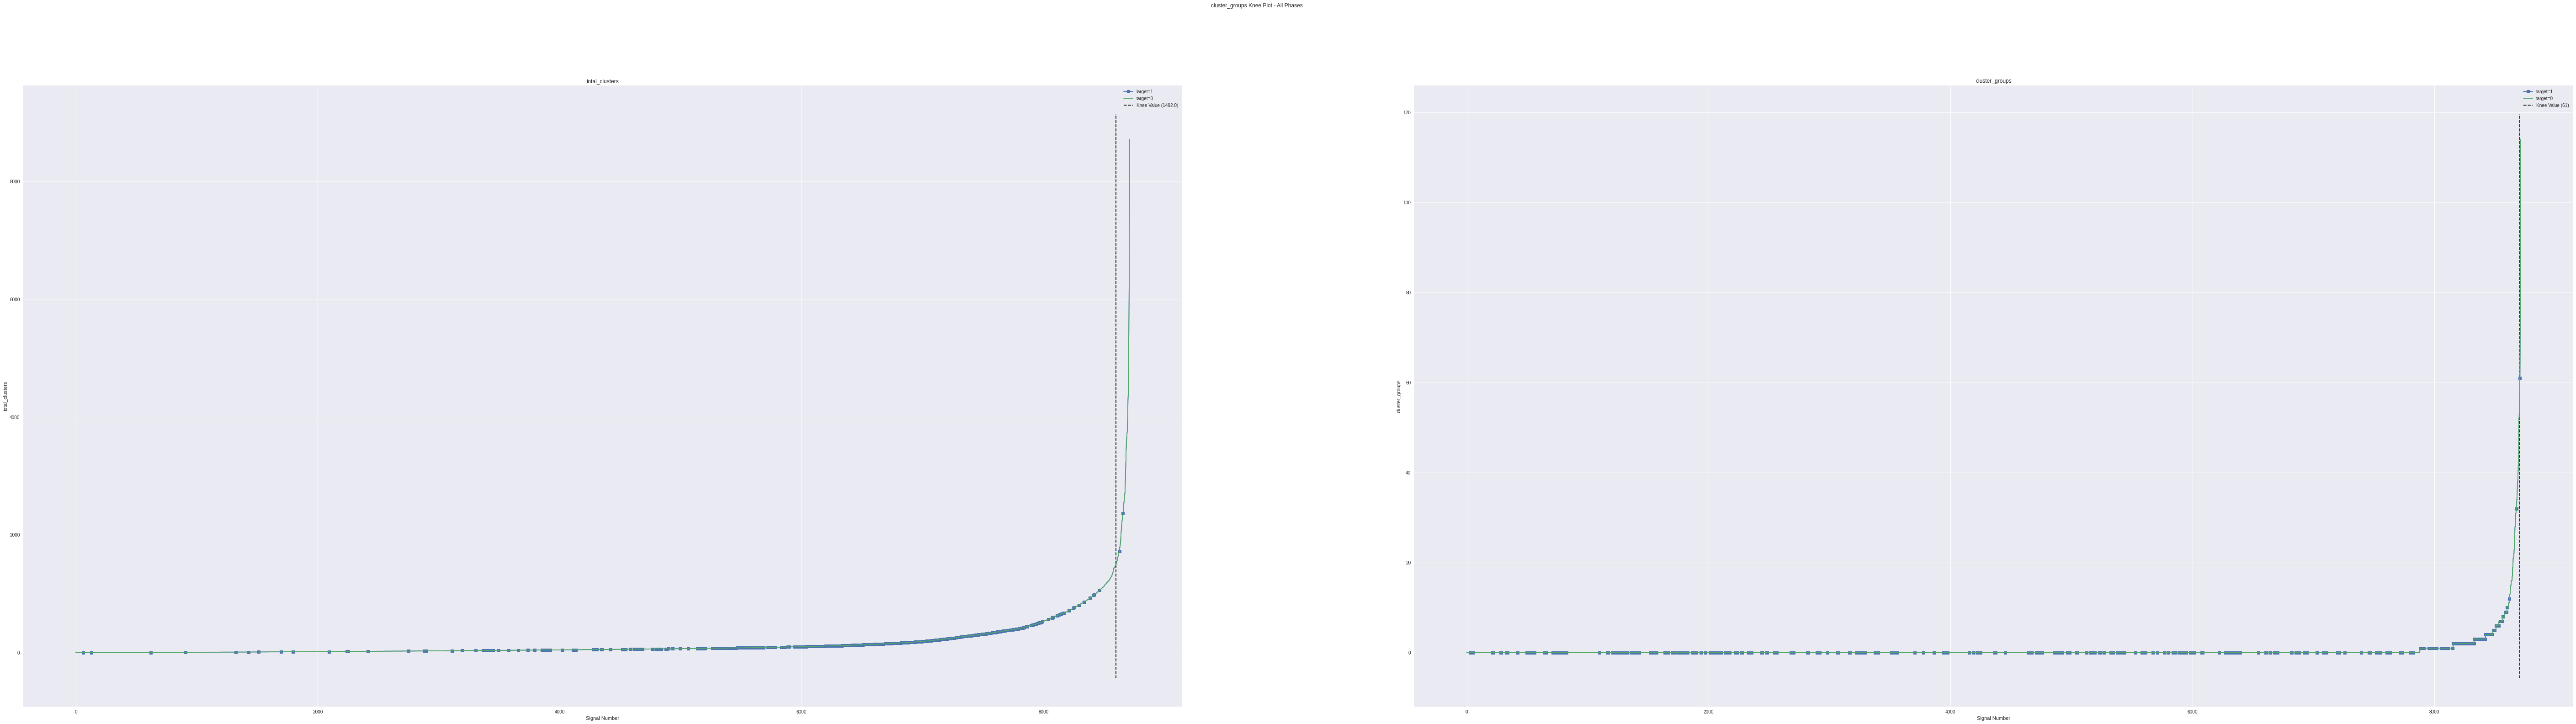

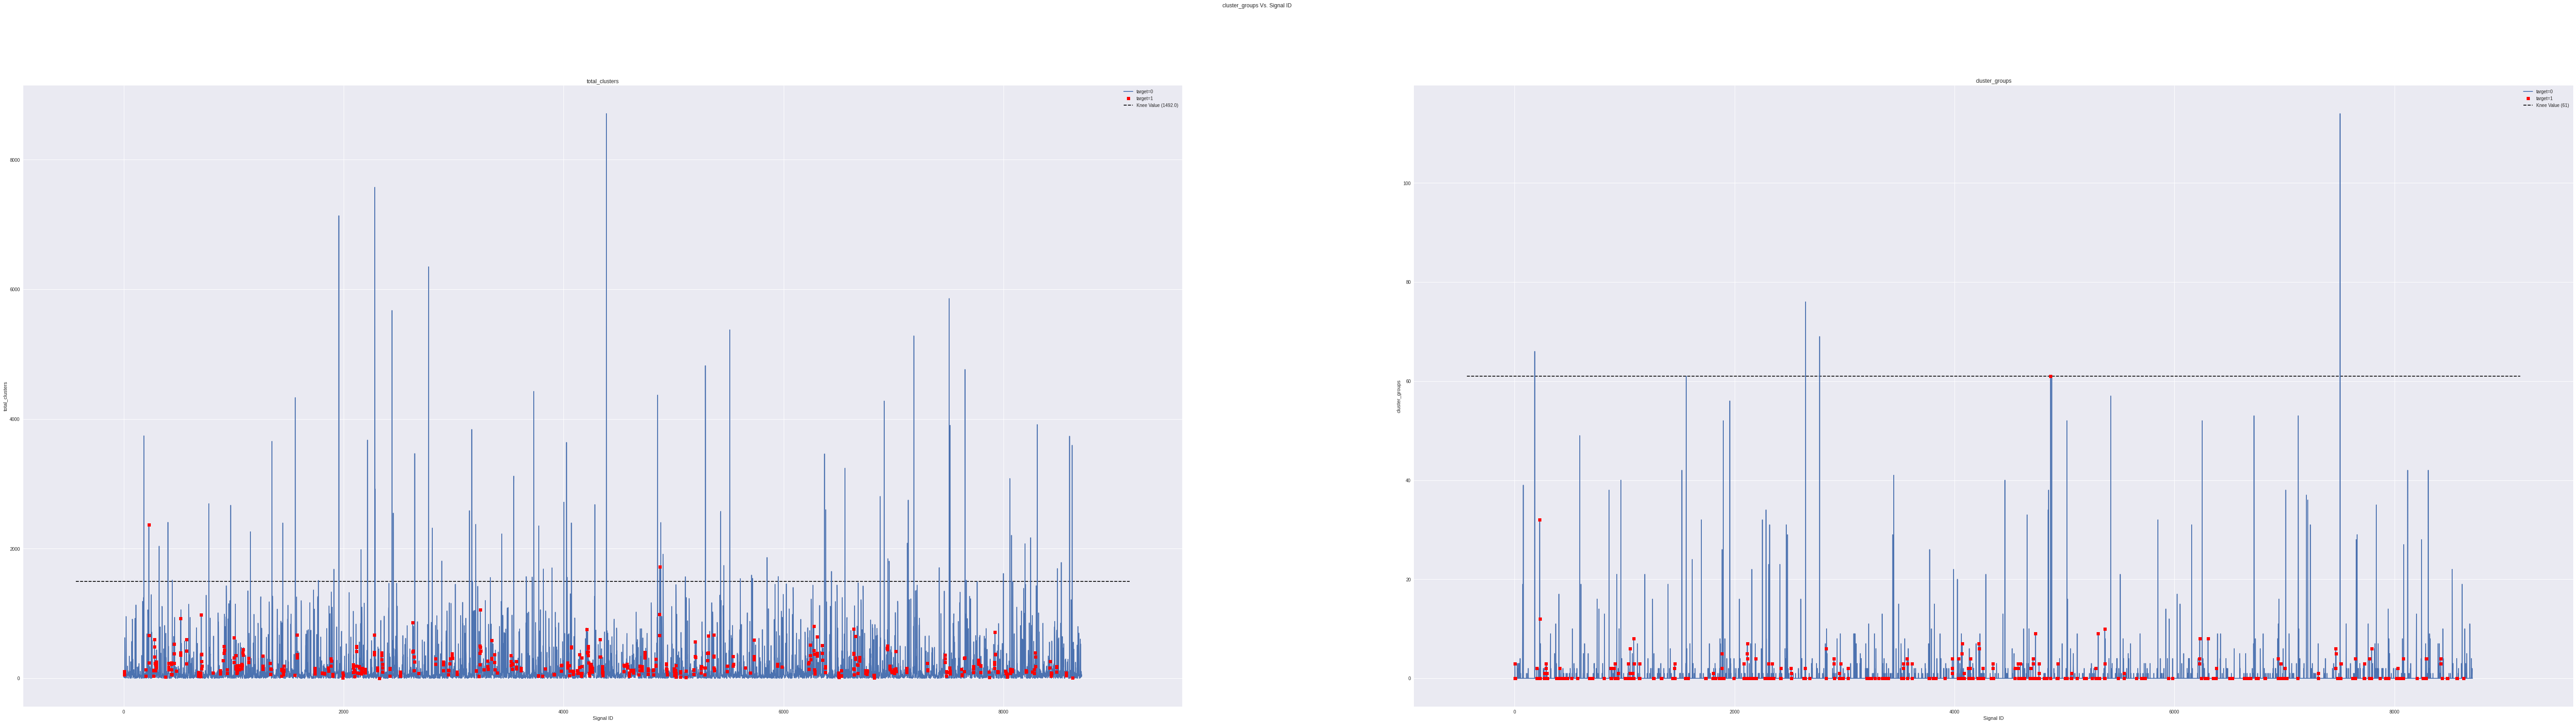

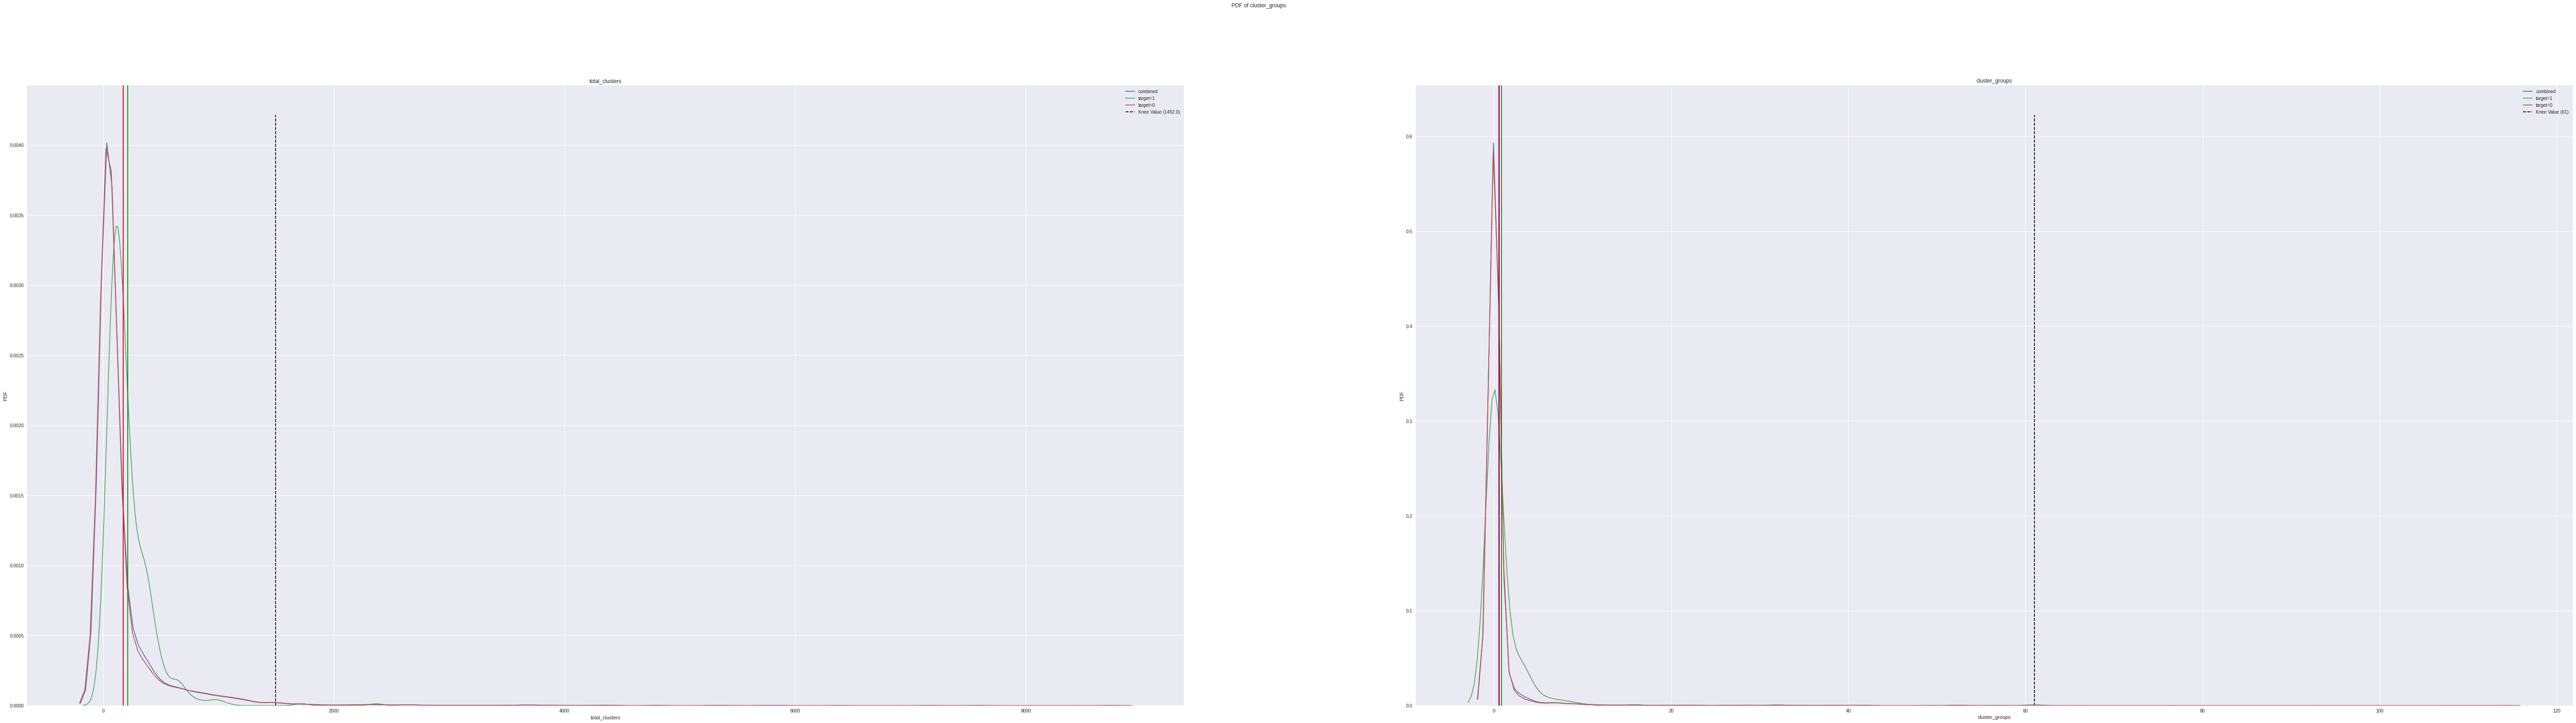

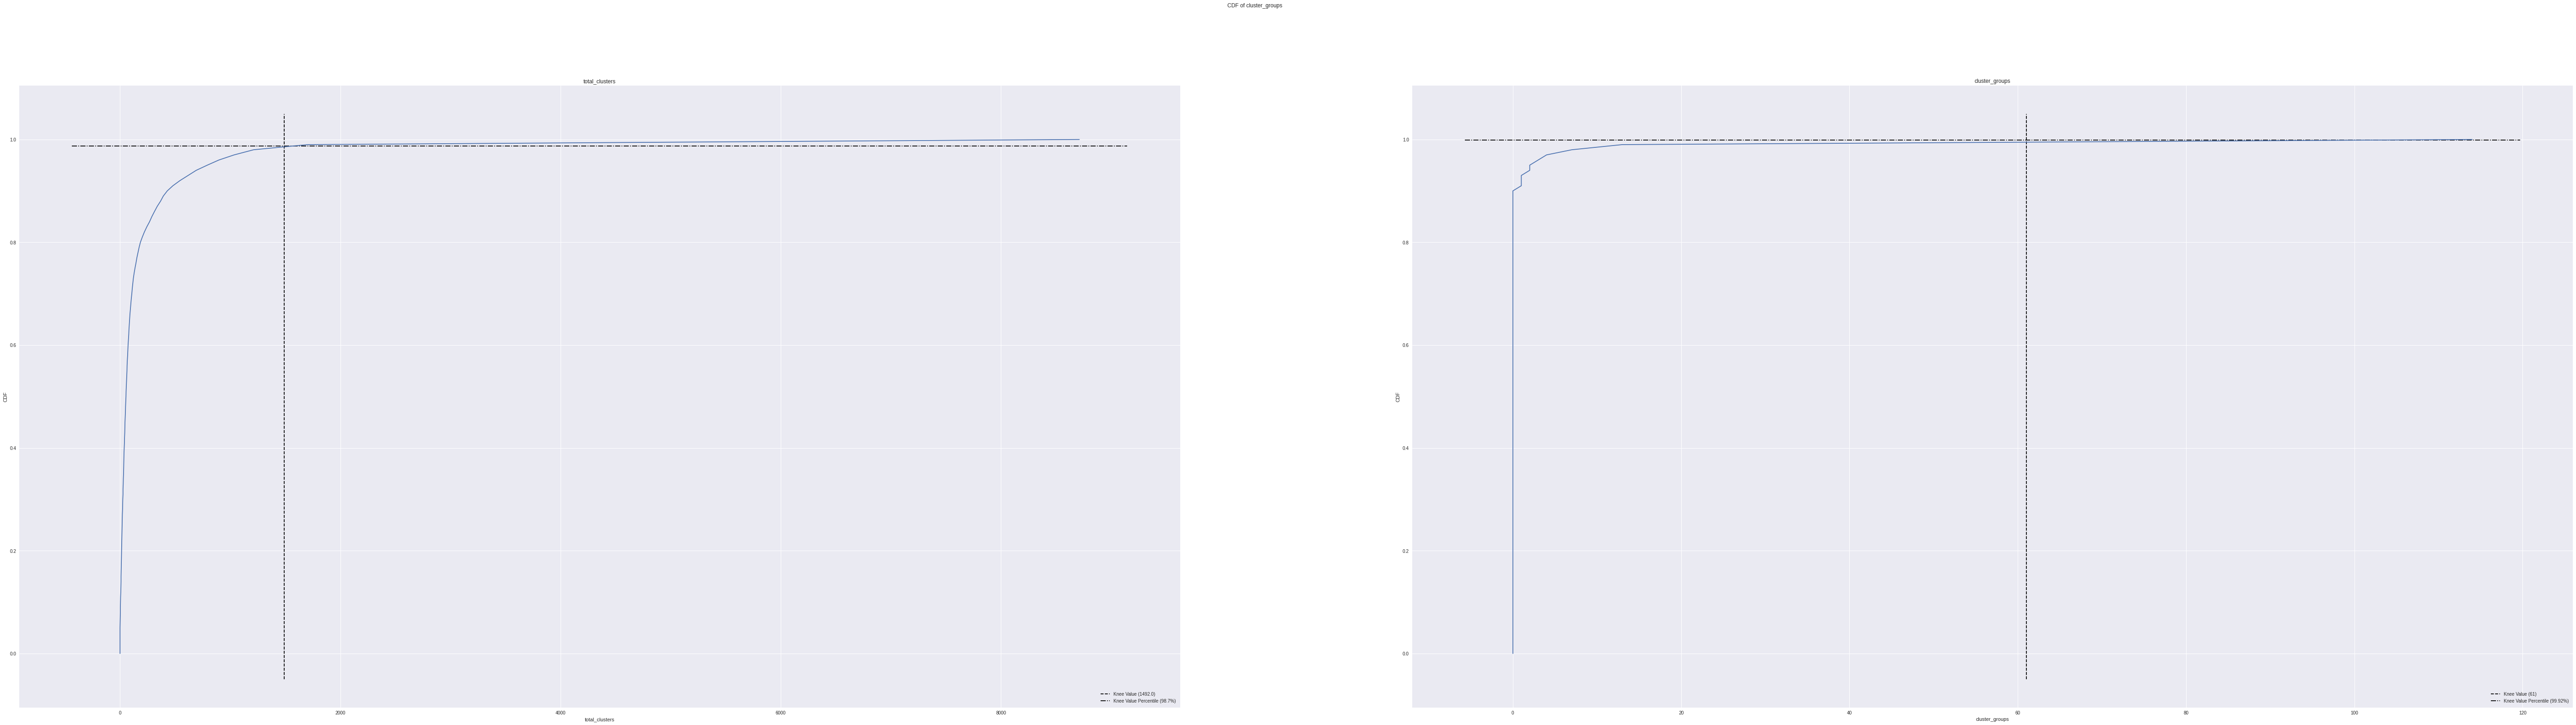

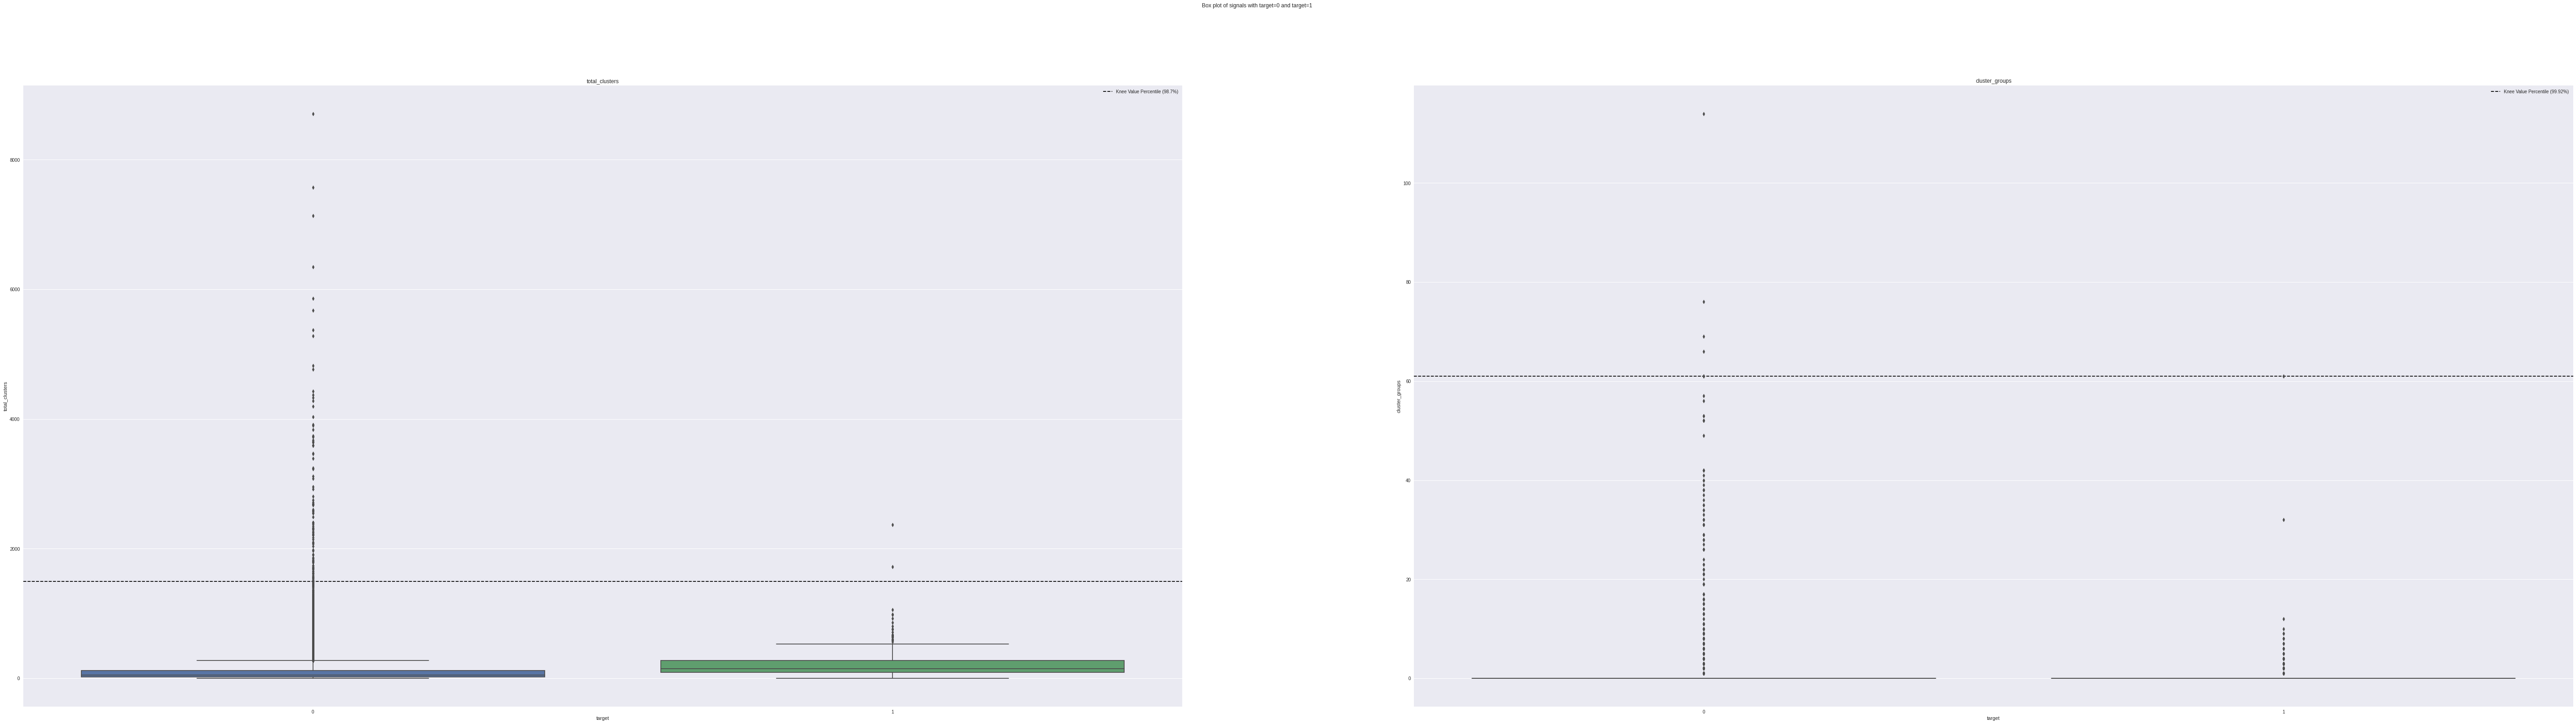

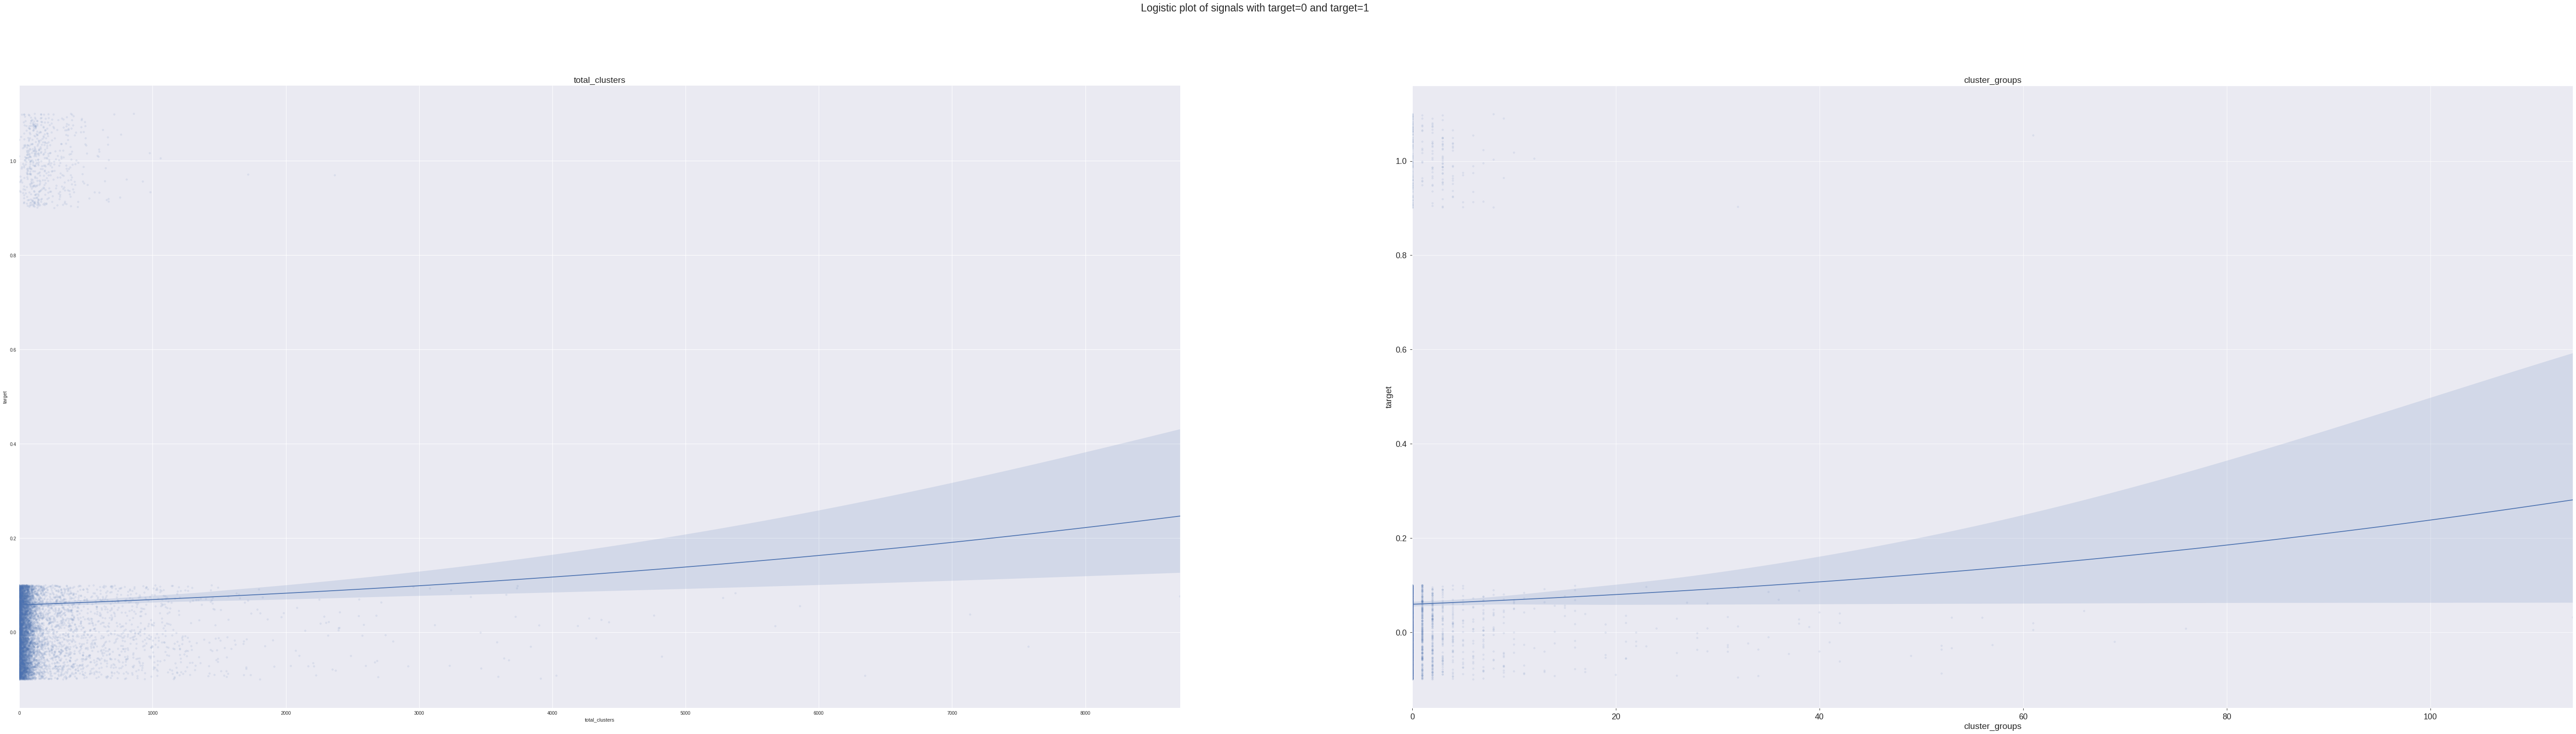

In [ ]:
peak_cluster_feats_df = pd.read_csv(path + f'peak_cluster_feats_10_train.csv')
peak_cluster_feats_df.drop(['Unnamed: 0'], axis=1, inplace=True)
peak_cluster_feats_df = pd.concat([metadata_train, peak_cluster_feats_df], axis=1)

plot_multi_compare(['total_clusters', 'cluster_groups'], 'one_phase', plt_list, peak_cluster_feats_df)

Observations:
*  Majority of the data points have total number of clusters less than 1492 clusters (which is 0.1865% of all the points in the signal).
*  Total number of cluster groups of most of the signals are less than 10.
*  Separation of IQRs of signals with target=1 and target=0 is not possible.
*  Linear separability of the signal with target=1 and target=0.

**25 percentile clusters**

*  2 consecutive peak indices of a signal are considered to be part of the same cluster if the difference between them is less than 25 percentile value of all the consecutive differences between the indices of that signal.
*  A cluster is considered as a cluster group if number of points in the cluster is greater than 2.

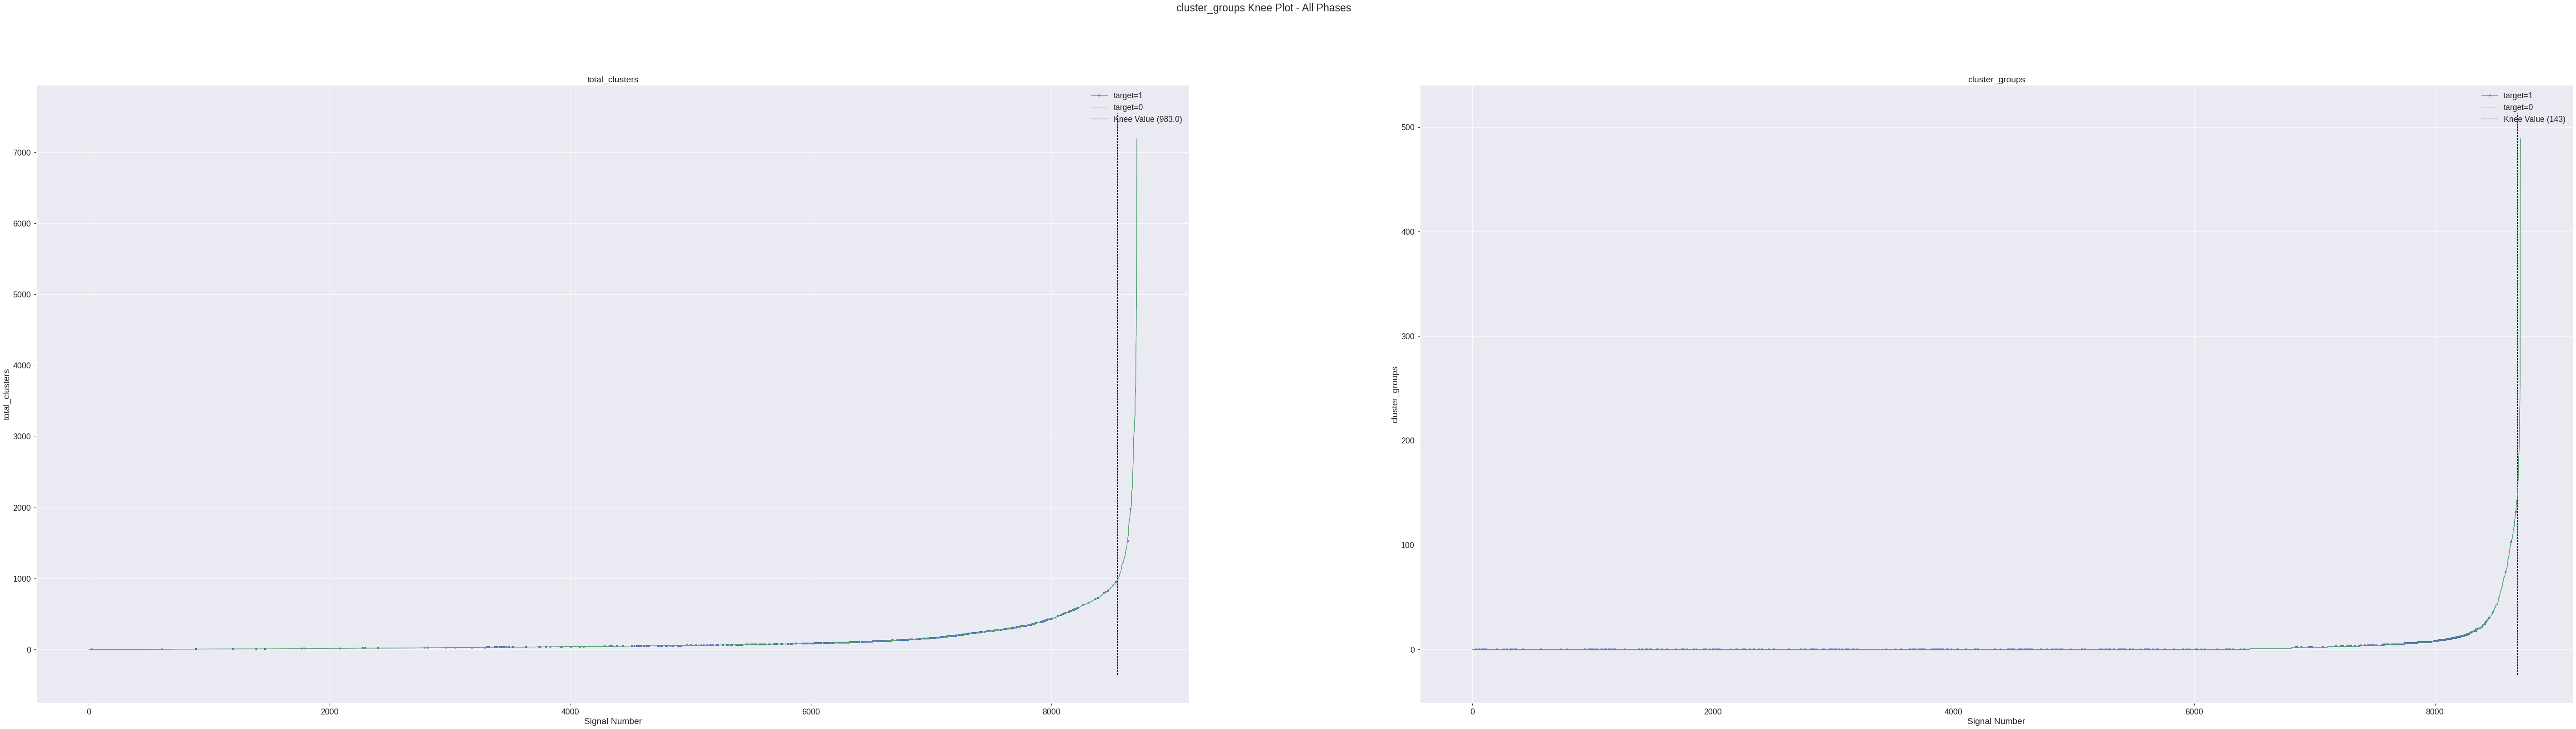

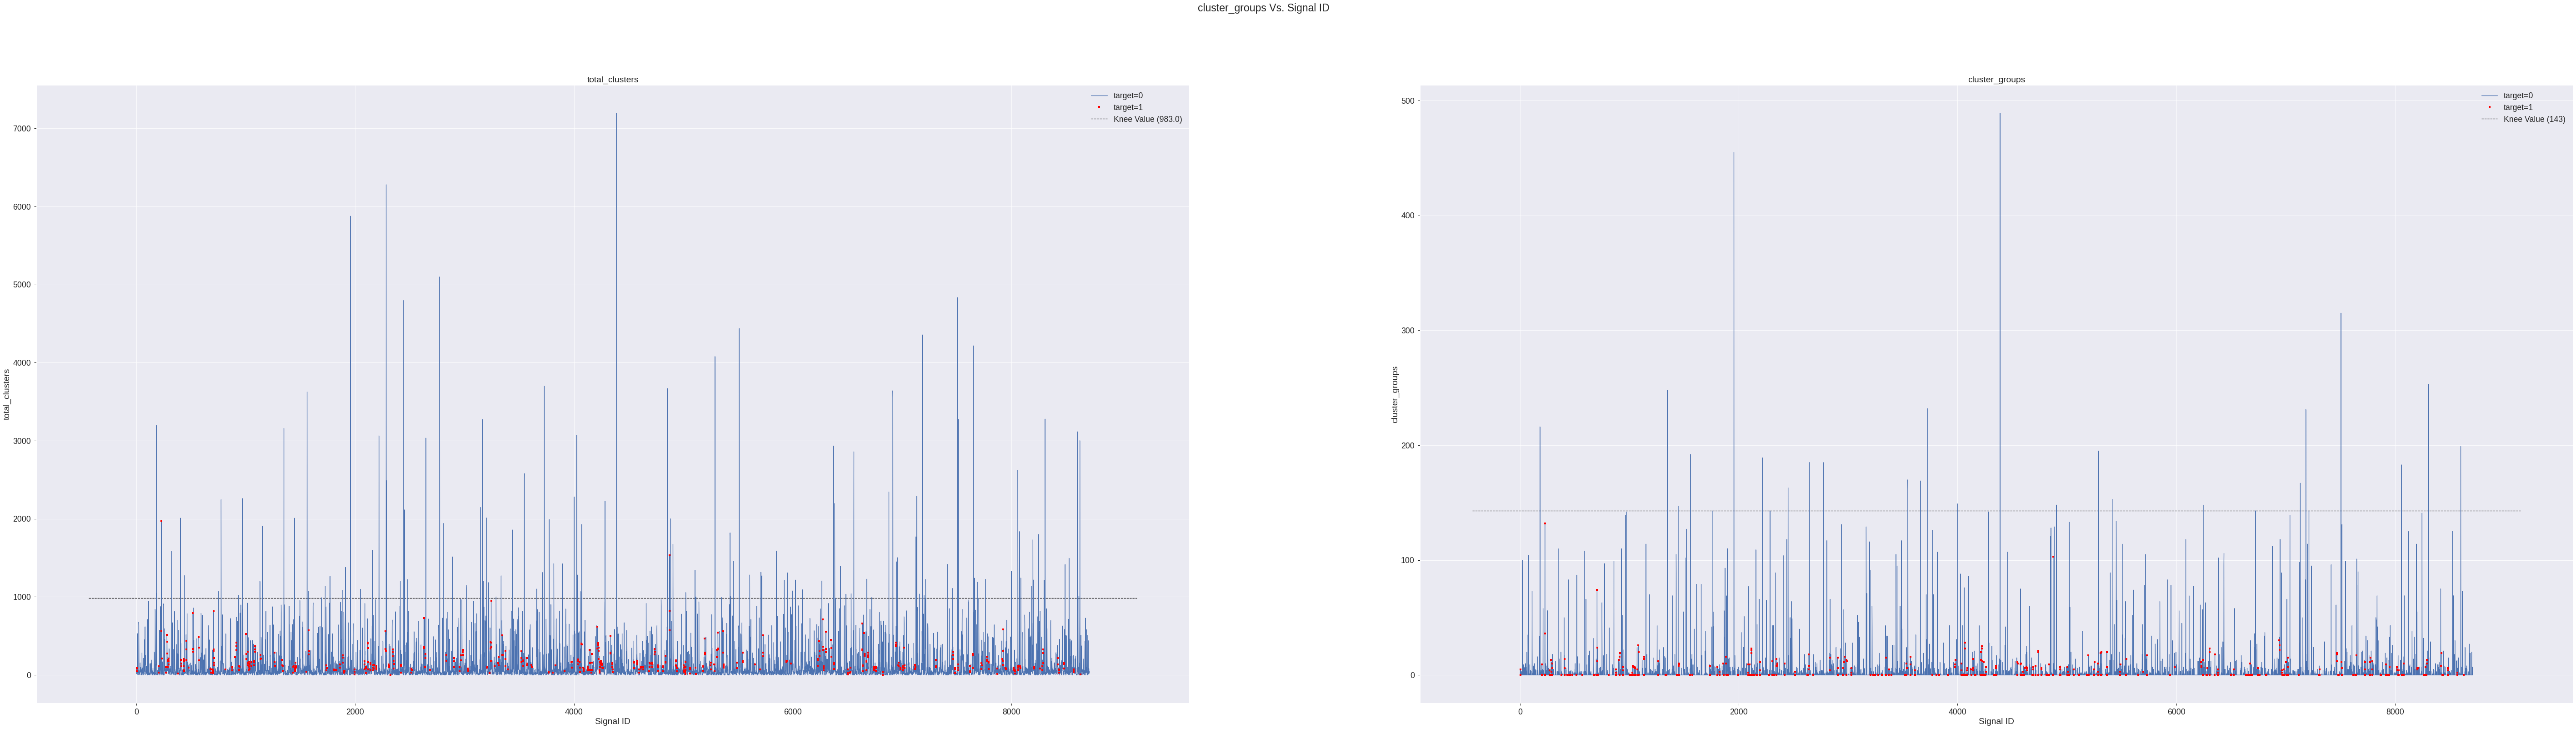

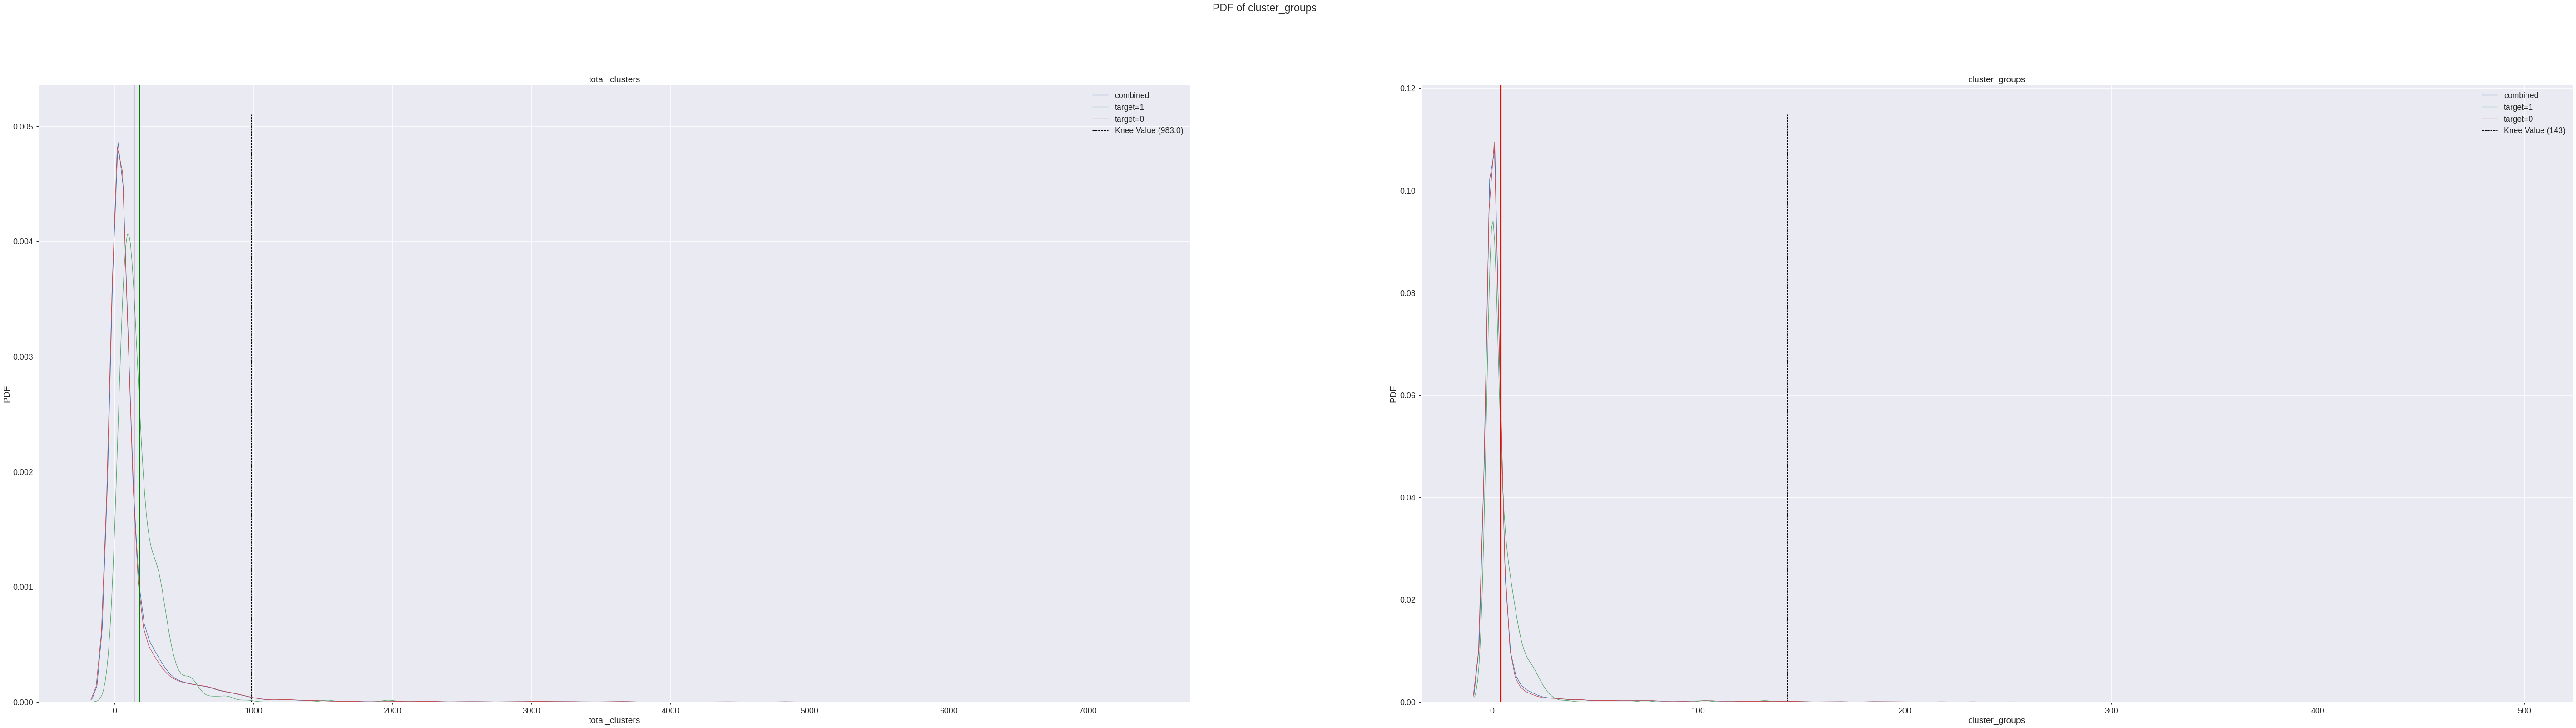

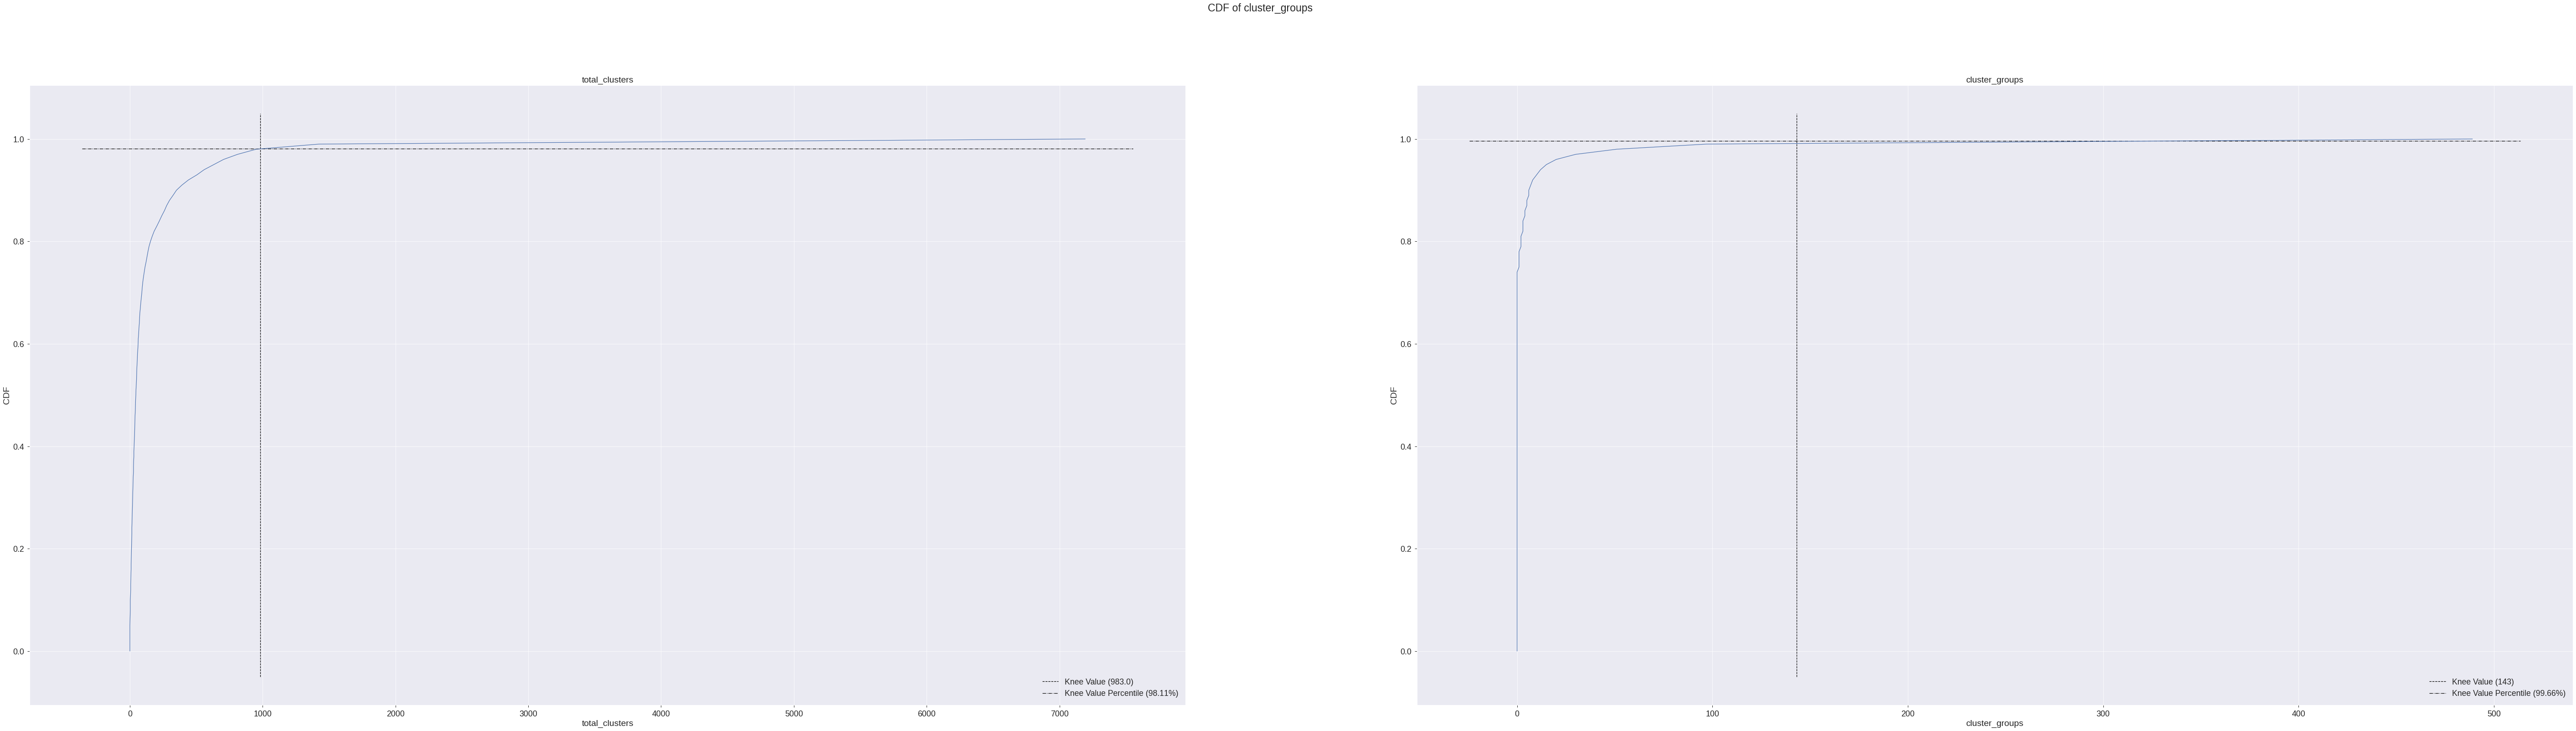

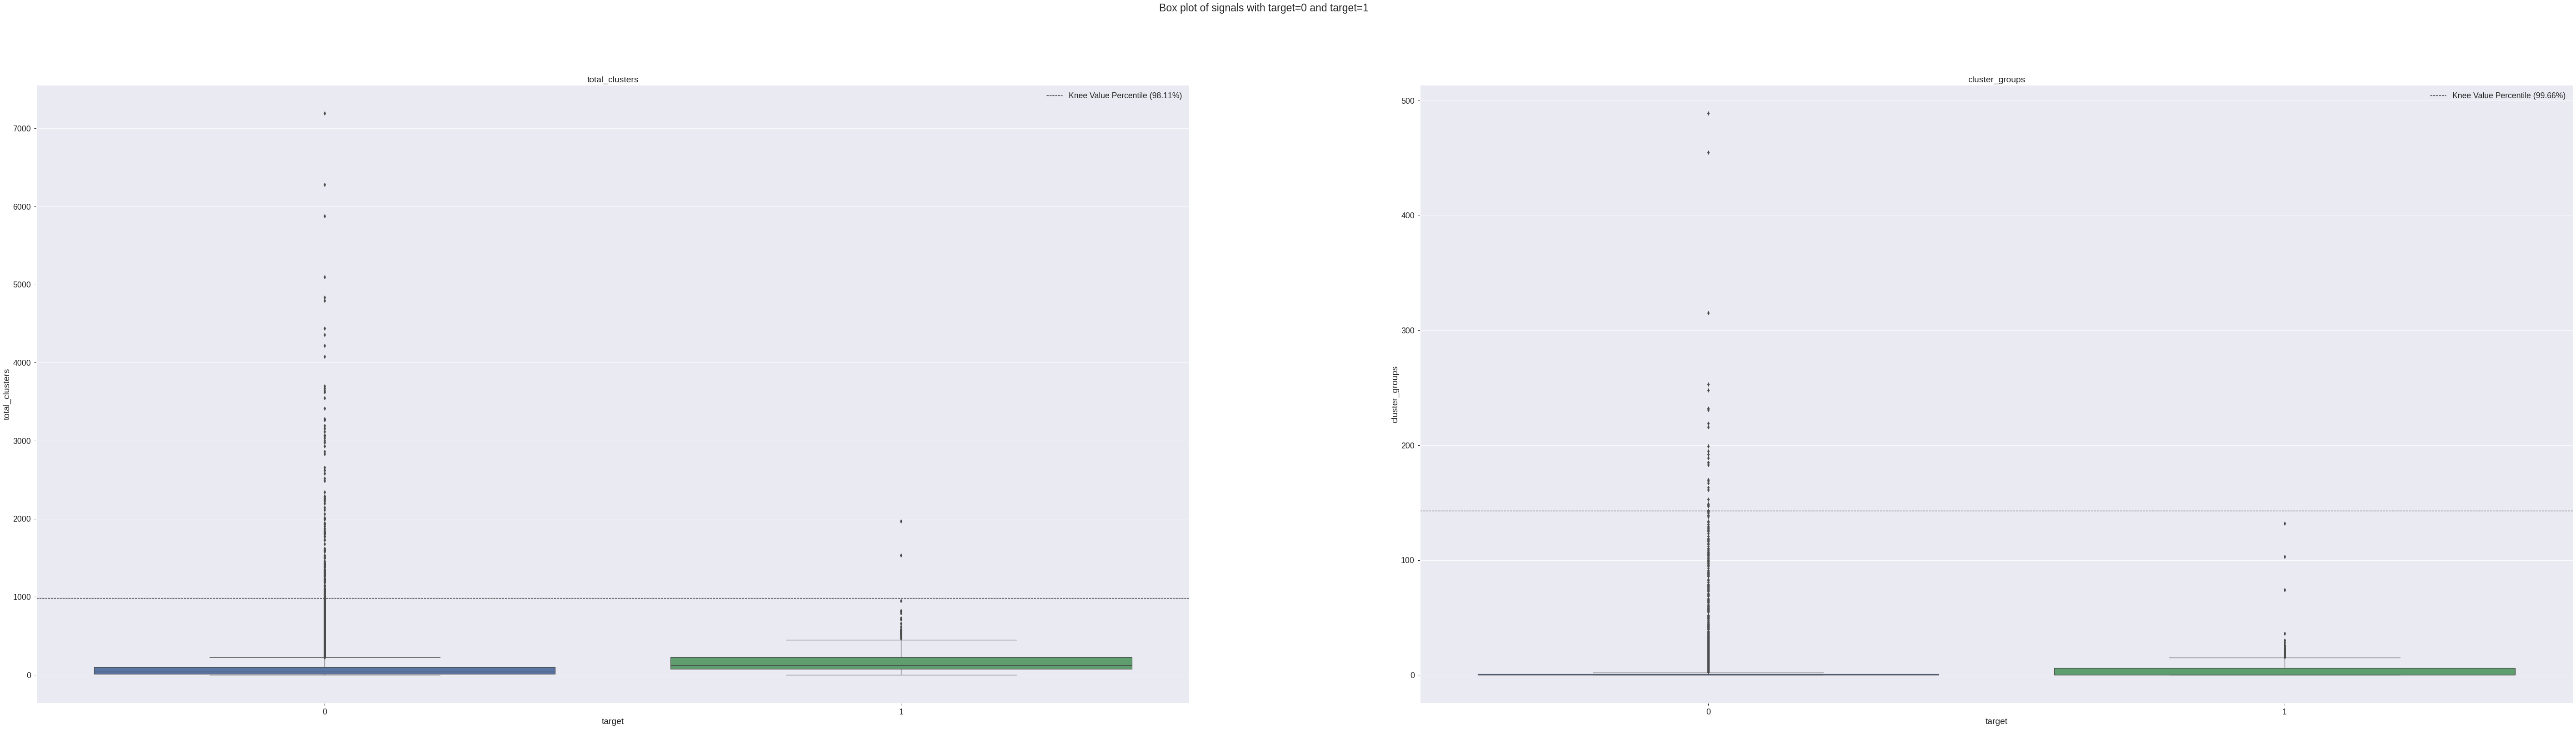

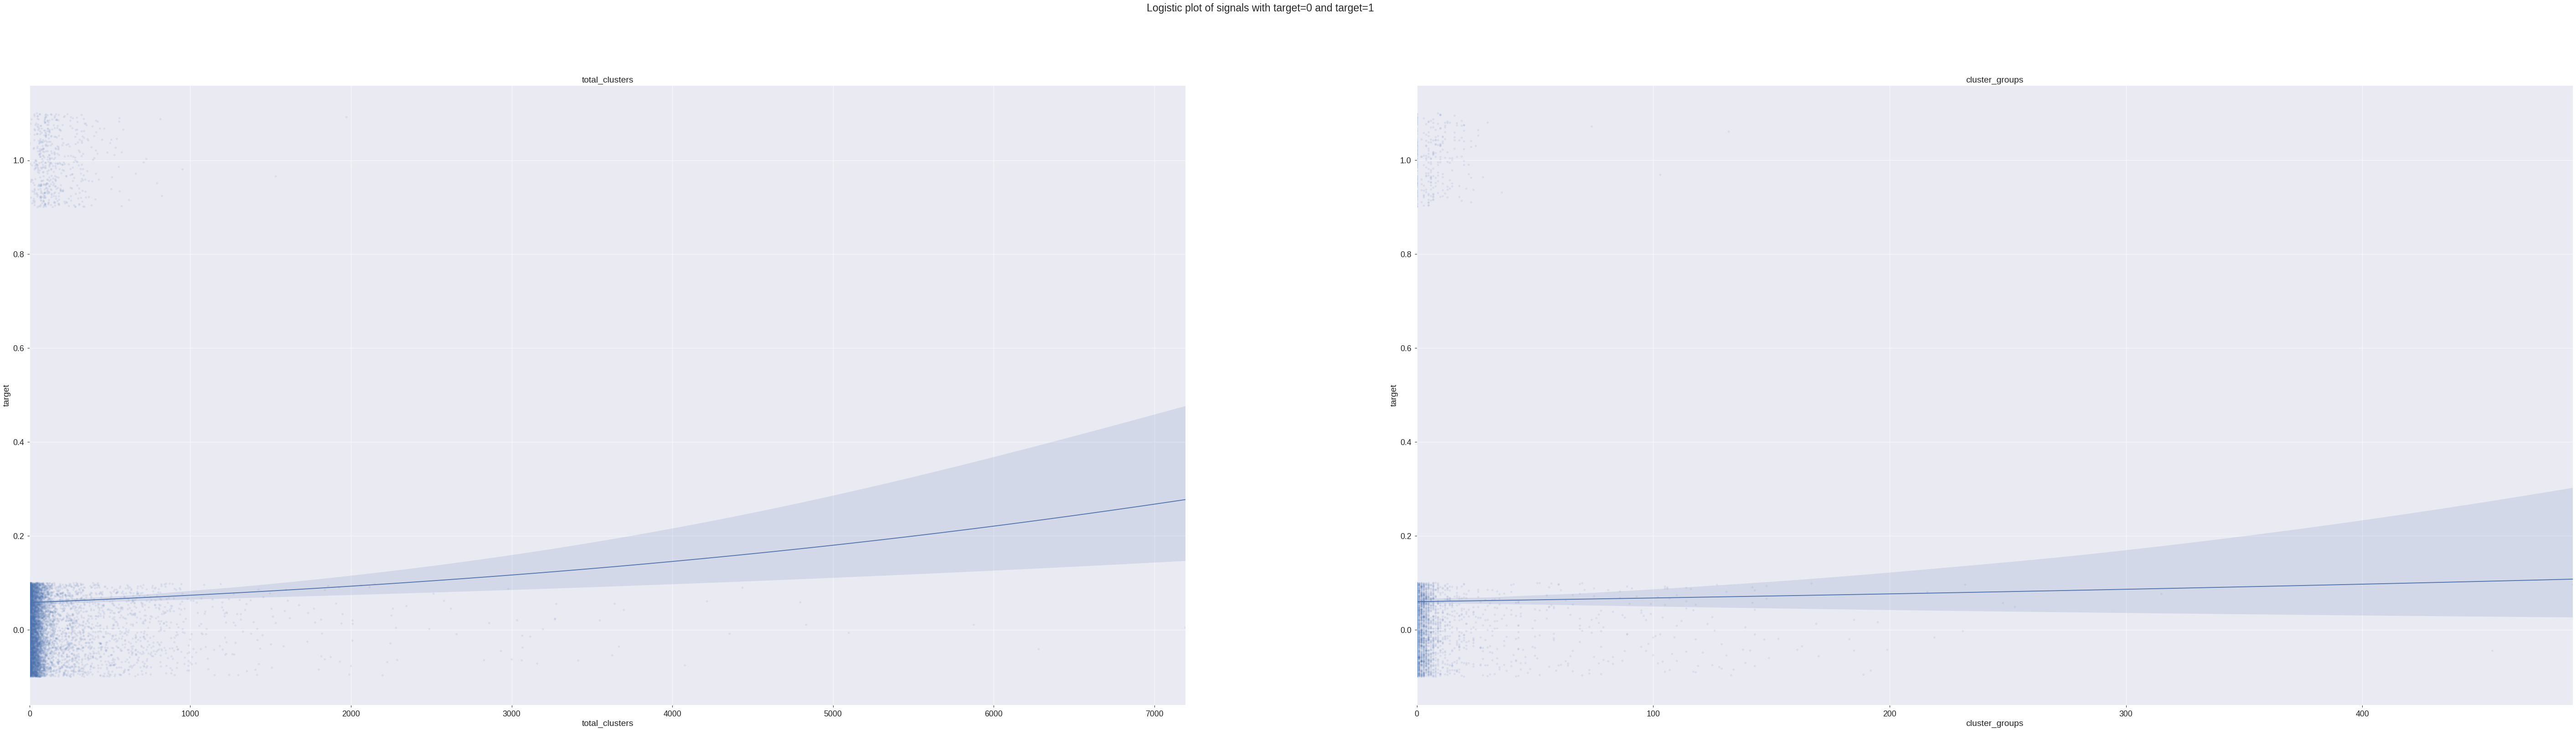

In [ ]:
peak_cluster_feats_df = pd.read_csv(path + f'peak_cluster_feats_25_train.csv')
peak_cluster_feats_df.drop(['Unnamed: 0'], axis=1, inplace=True)
peak_cluster_feats_df = pd.concat([metadata_train, peak_cluster_feats_df], axis=1)

plot_multi_compare(['total_clusters', 'cluster_groups'], 'one_phase', plt_list, peak_cluster_feats_df)

Observations:
*  Majority of the data points have total number of clusters less than 983 clusters (which is 0.122% of all the points in the signal).
*  Total number of cluster groups of most of the signals are less than 50.
*  Separation of IQRs of signals with target=1 and target=0 is not possible.
*  Linear separability of the signal with target=1 and target=0.

**50 percentile clusters**

*  2 consecutive peak indices of a signal are considered to be part of the same cluster if the difference between them is less than 50 percentile value of all the consecutive differences between the indices of that signal.
*  A cluster is considered as a cluster group if number of points in the cluster is greater than 2.

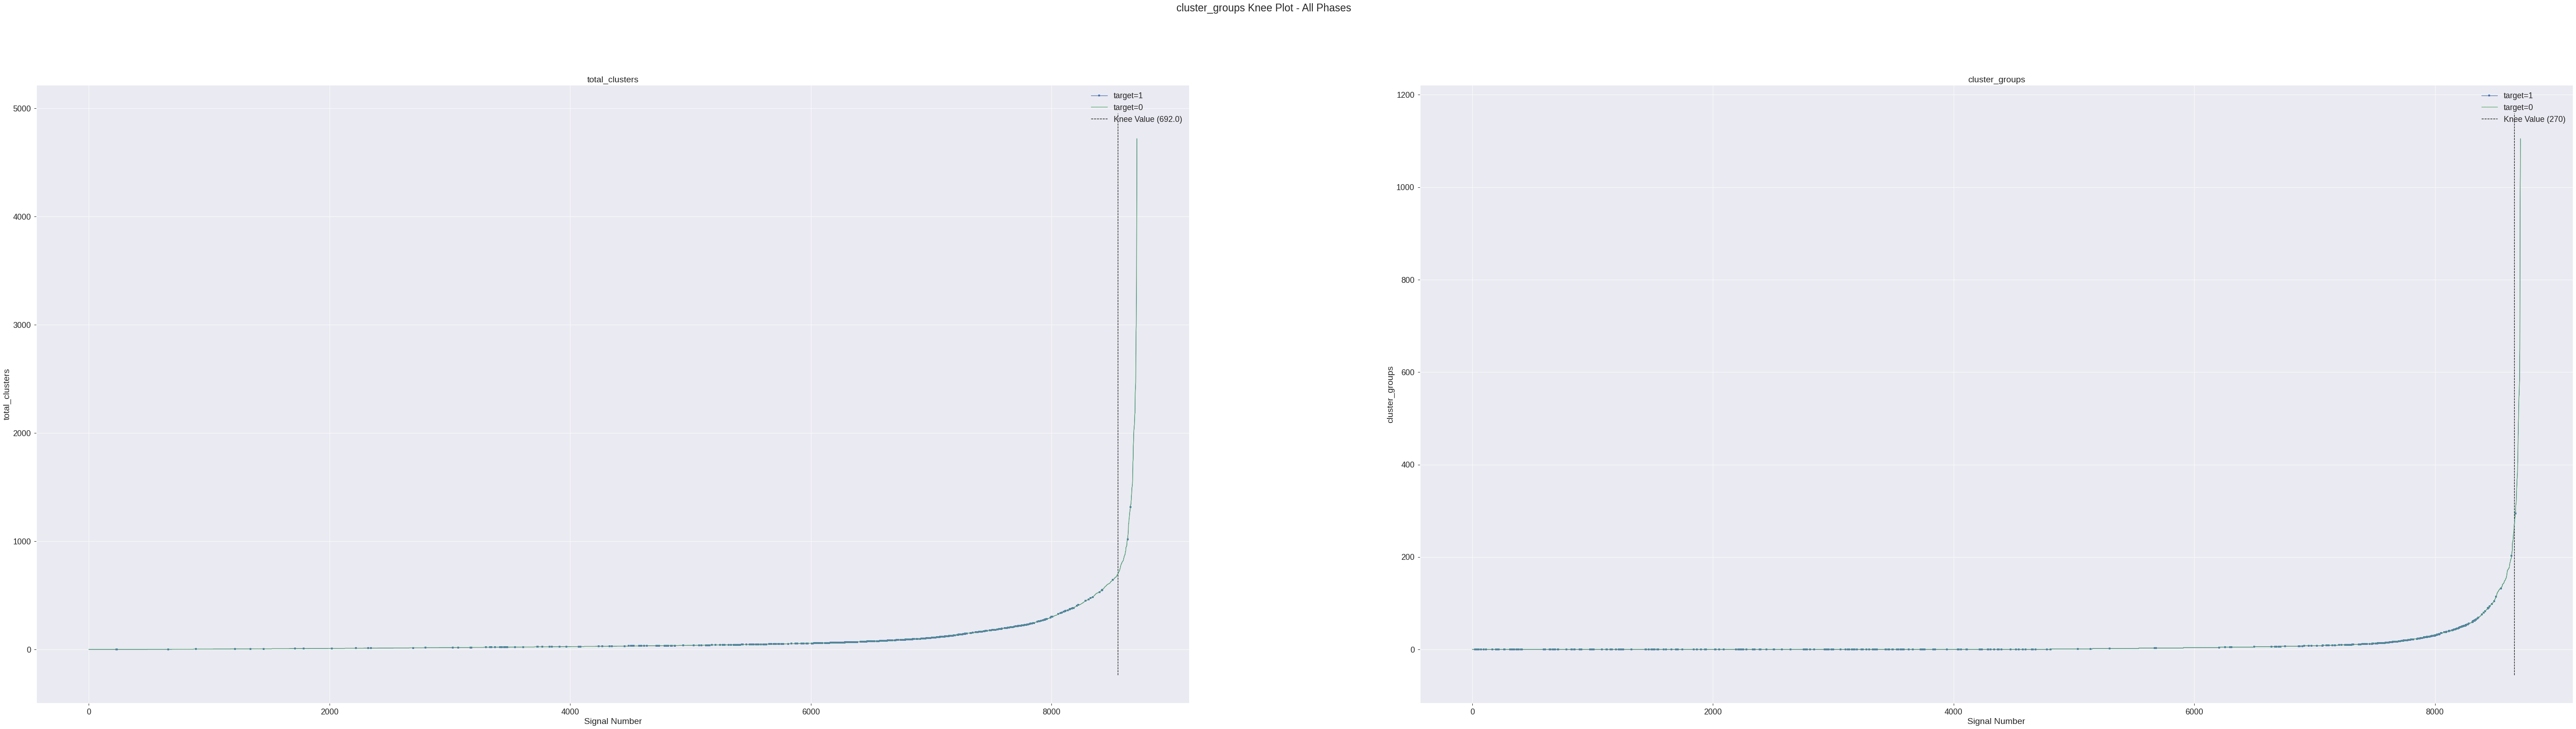

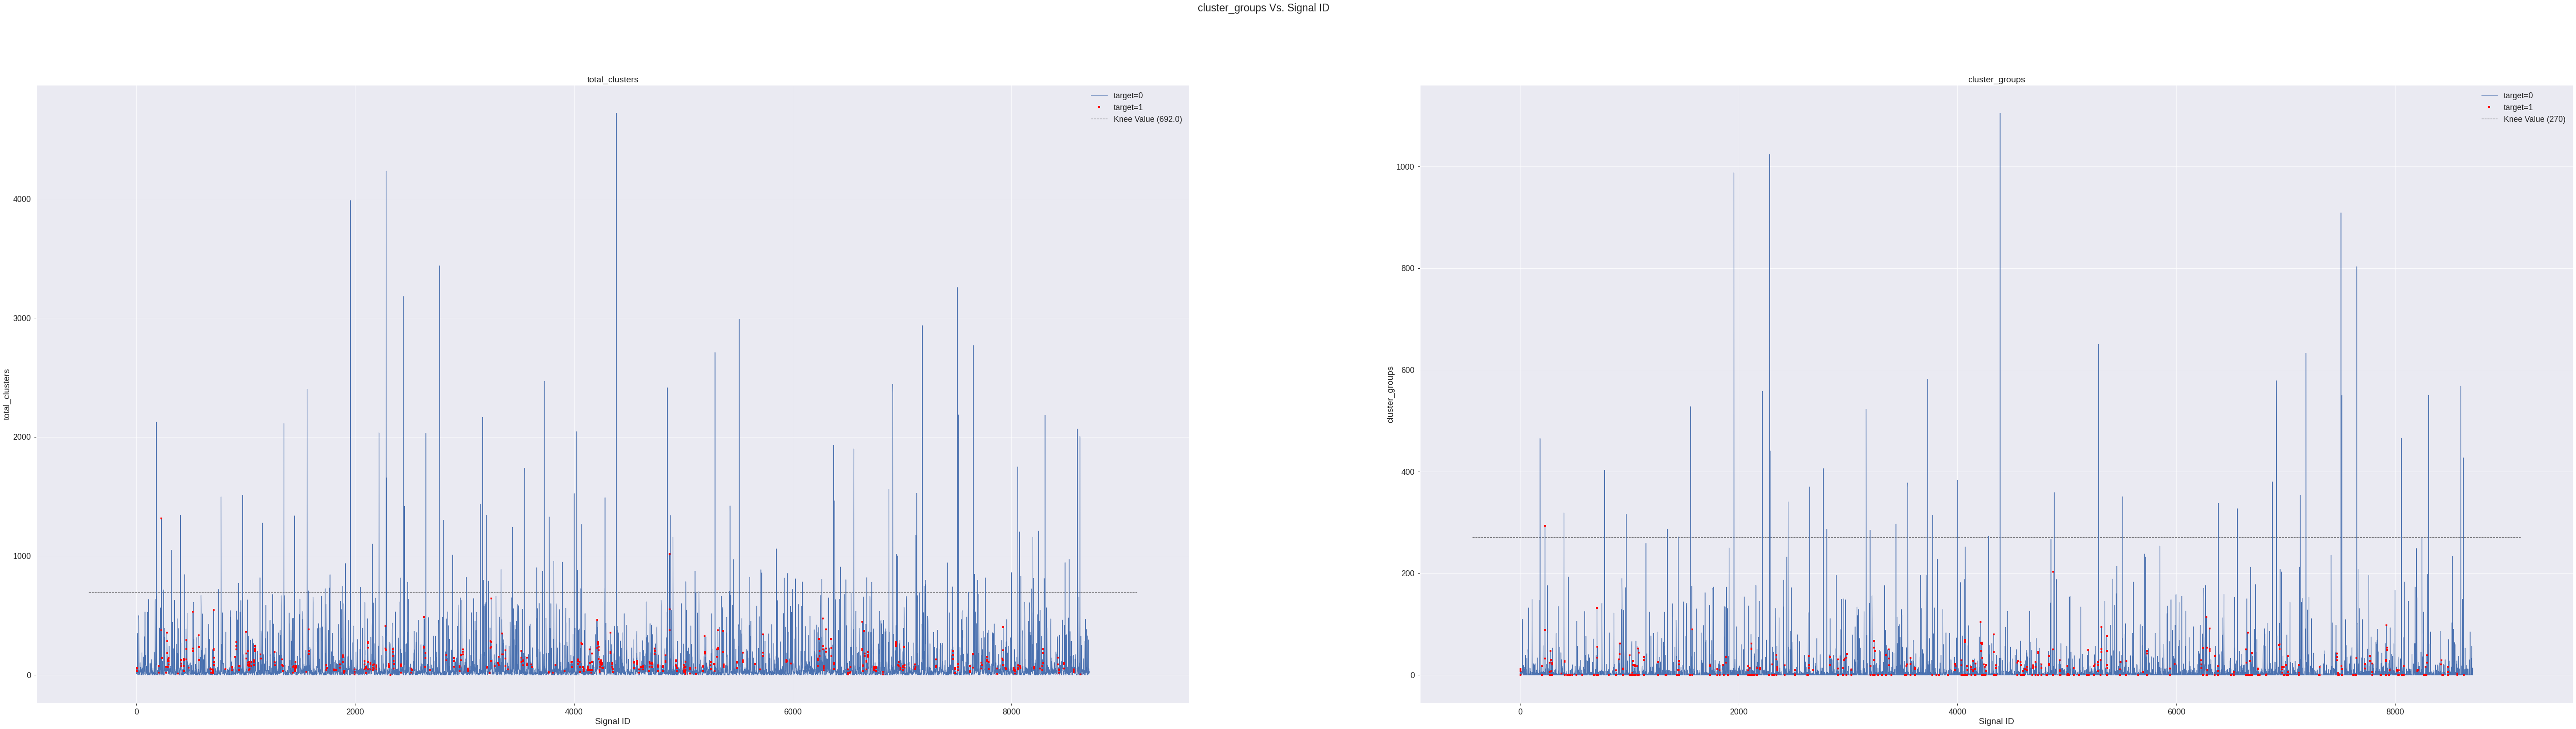

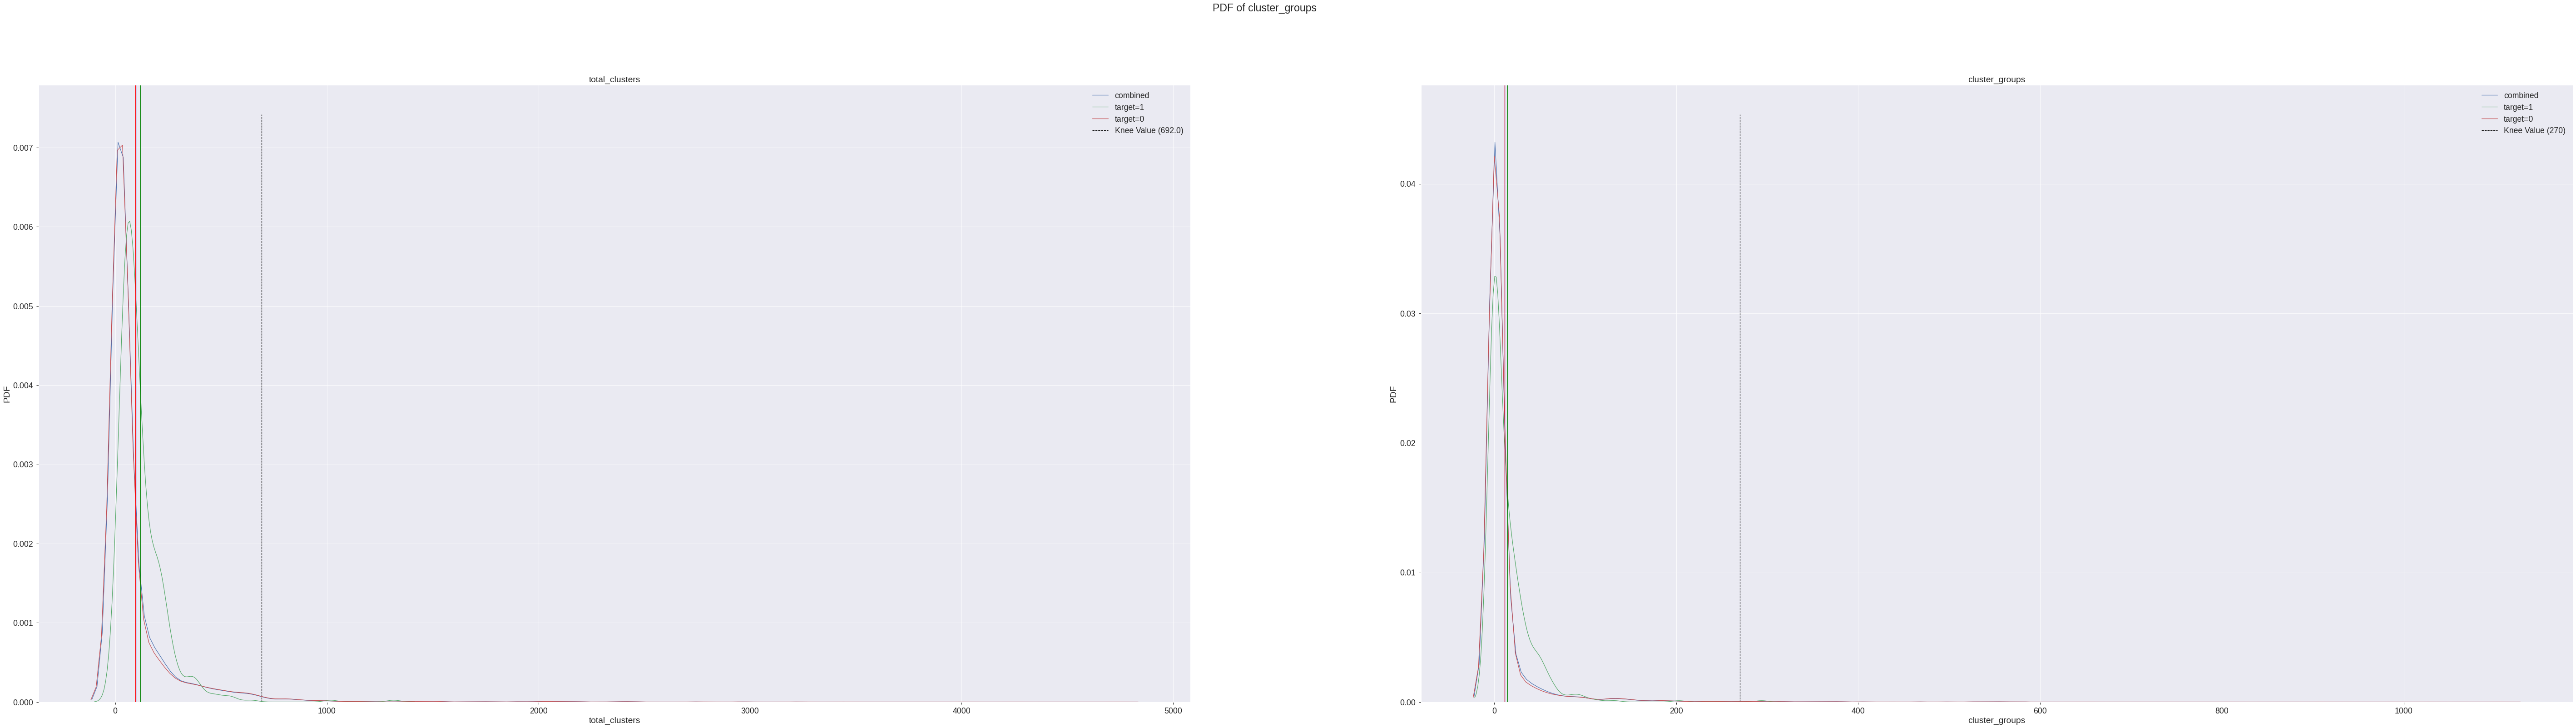

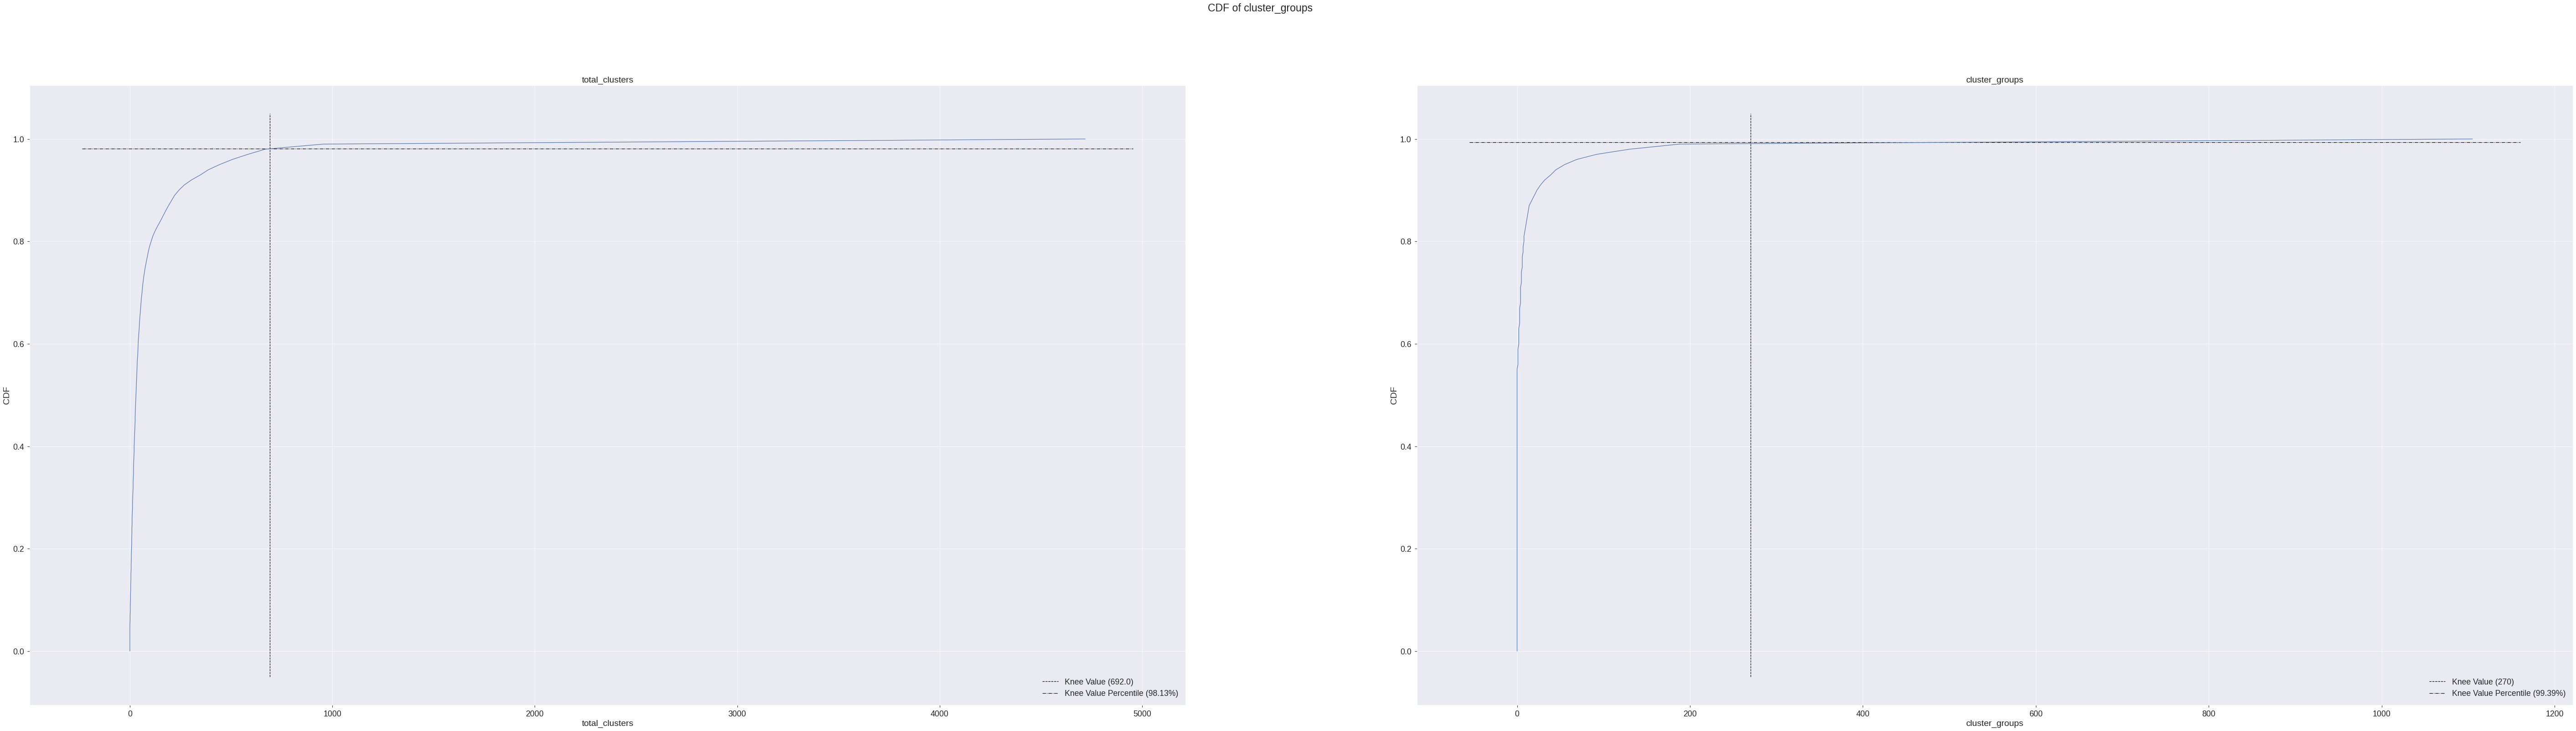

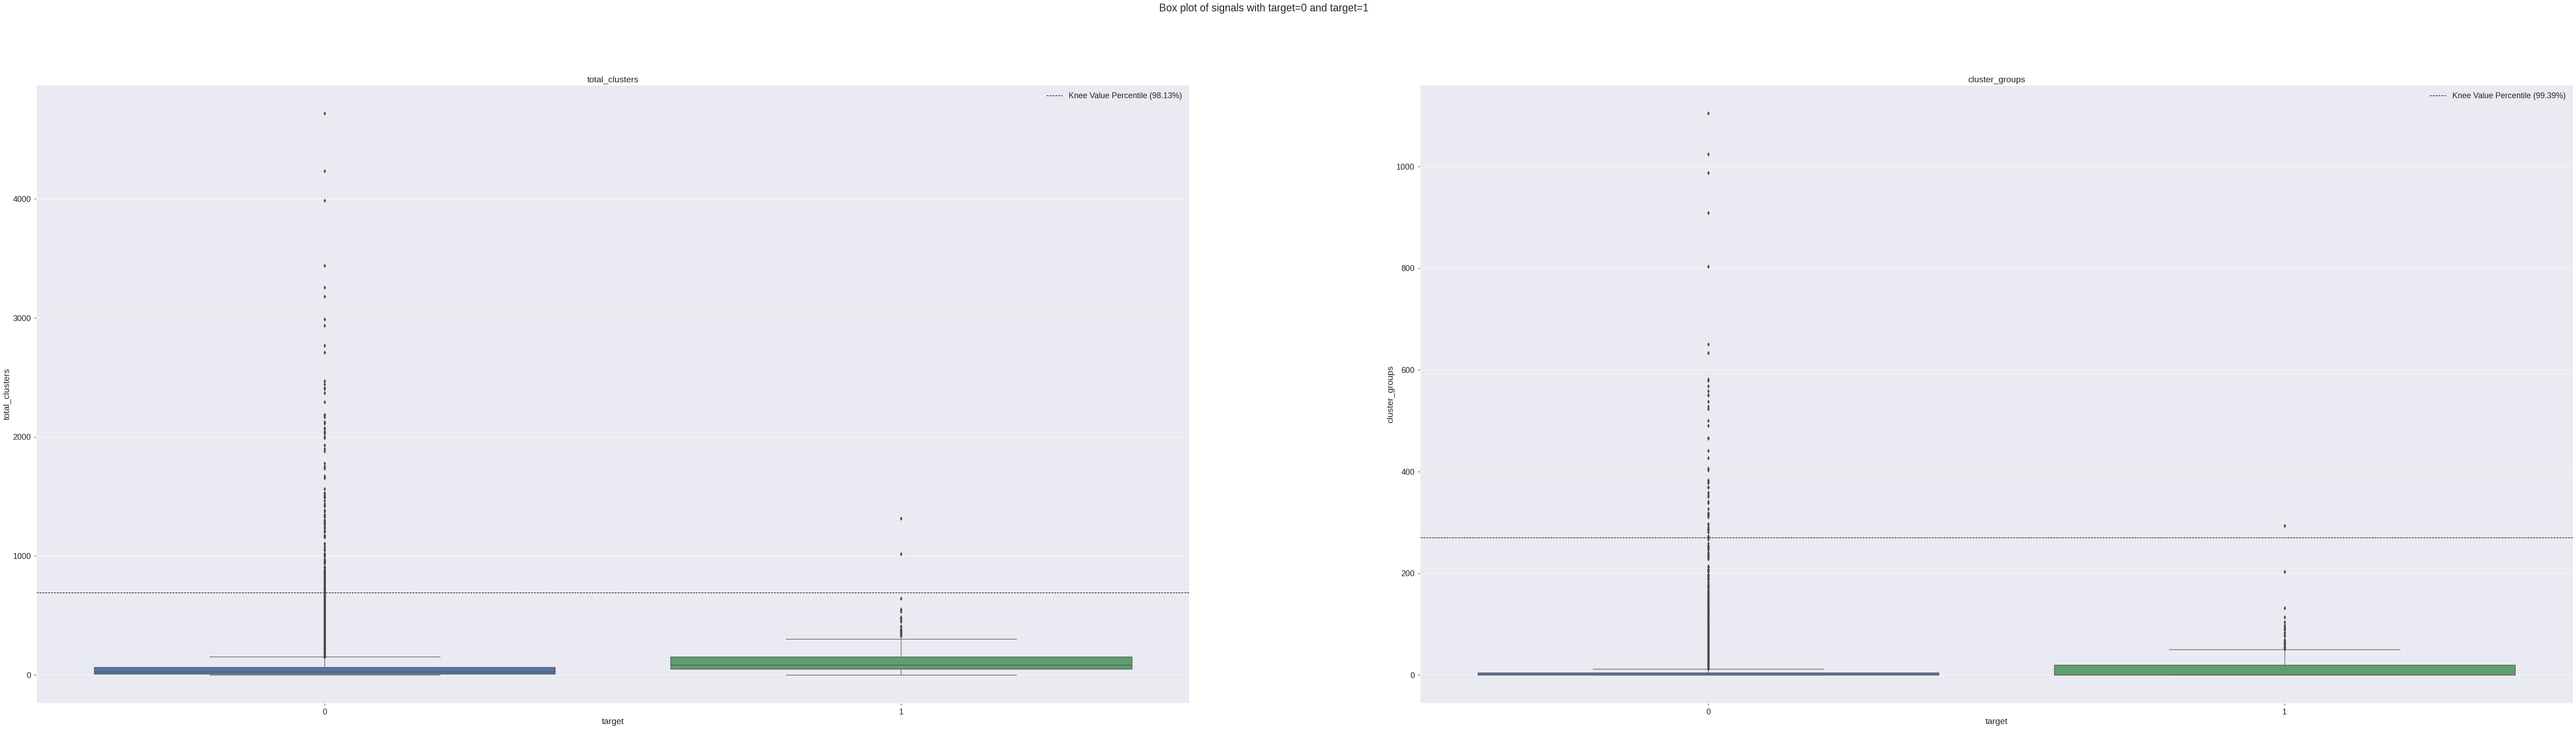

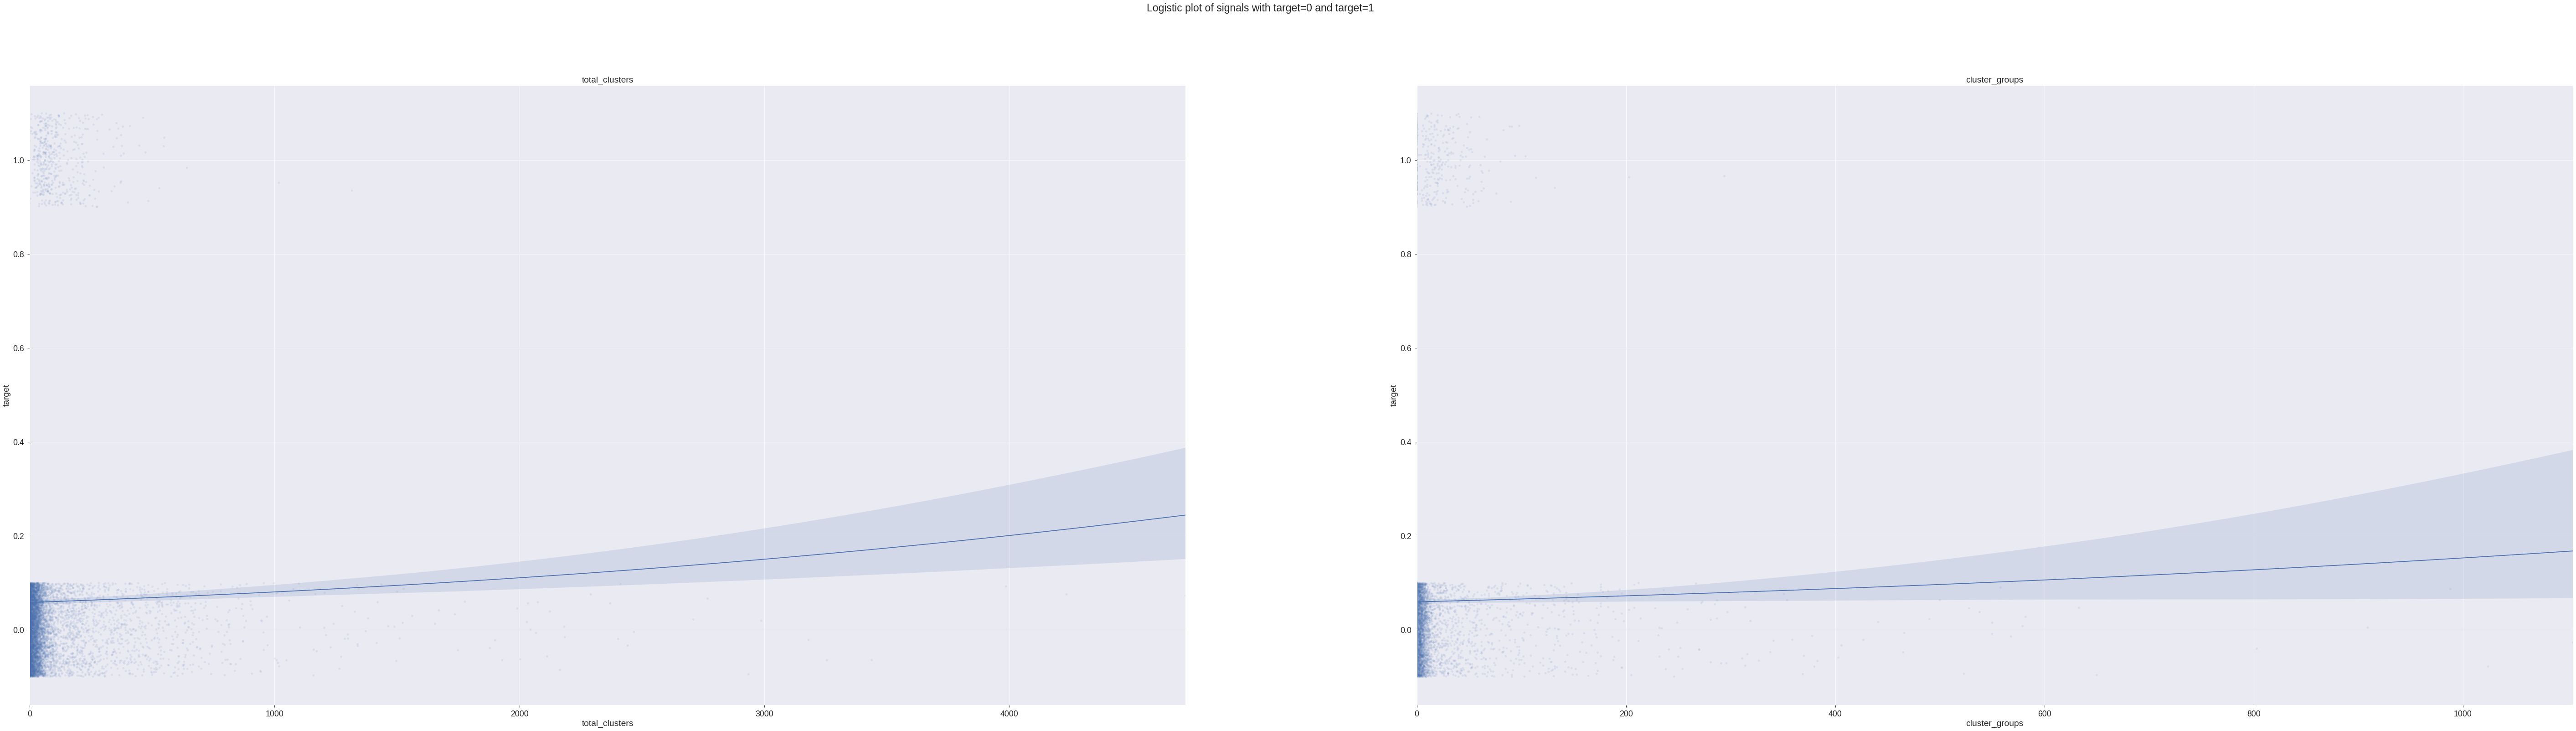

In [ ]:
peak_cluster_feats_df = pd.read_csv(path + f'peak_cluster_feats_50_train.csv')
peak_cluster_feats_df.drop(['Unnamed: 0'], axis=1, inplace=True)
peak_cluster_feats_df = pd.concat([metadata_train, peak_cluster_feats_df], axis=1)

plot_multi_compare(['total_clusters', 'cluster_groups'], 'one_phase', plt_list, peak_cluster_feats_df)

Observations:
*  Majority of the data points have total number of clusters less than 692 clusters (which is 0.0865% of all the points in the signal).
*  Total number of cluster groups of most of the signals are less than 200.
*  Separation of IQRs of signals with target=1 and target=0 is not possible.
*  Linear separability of the signal with target=1 and target=0.

**75 percentile clusters**

*  2 consecutive peak indices of a signal are considered to be part of the same cluster if the difference between them is less than 75 percentile value of all the consecutive differences between the indices of that signal.
*  A cluster is considered as a cluster group if number of points in the cluster is greater than 2.

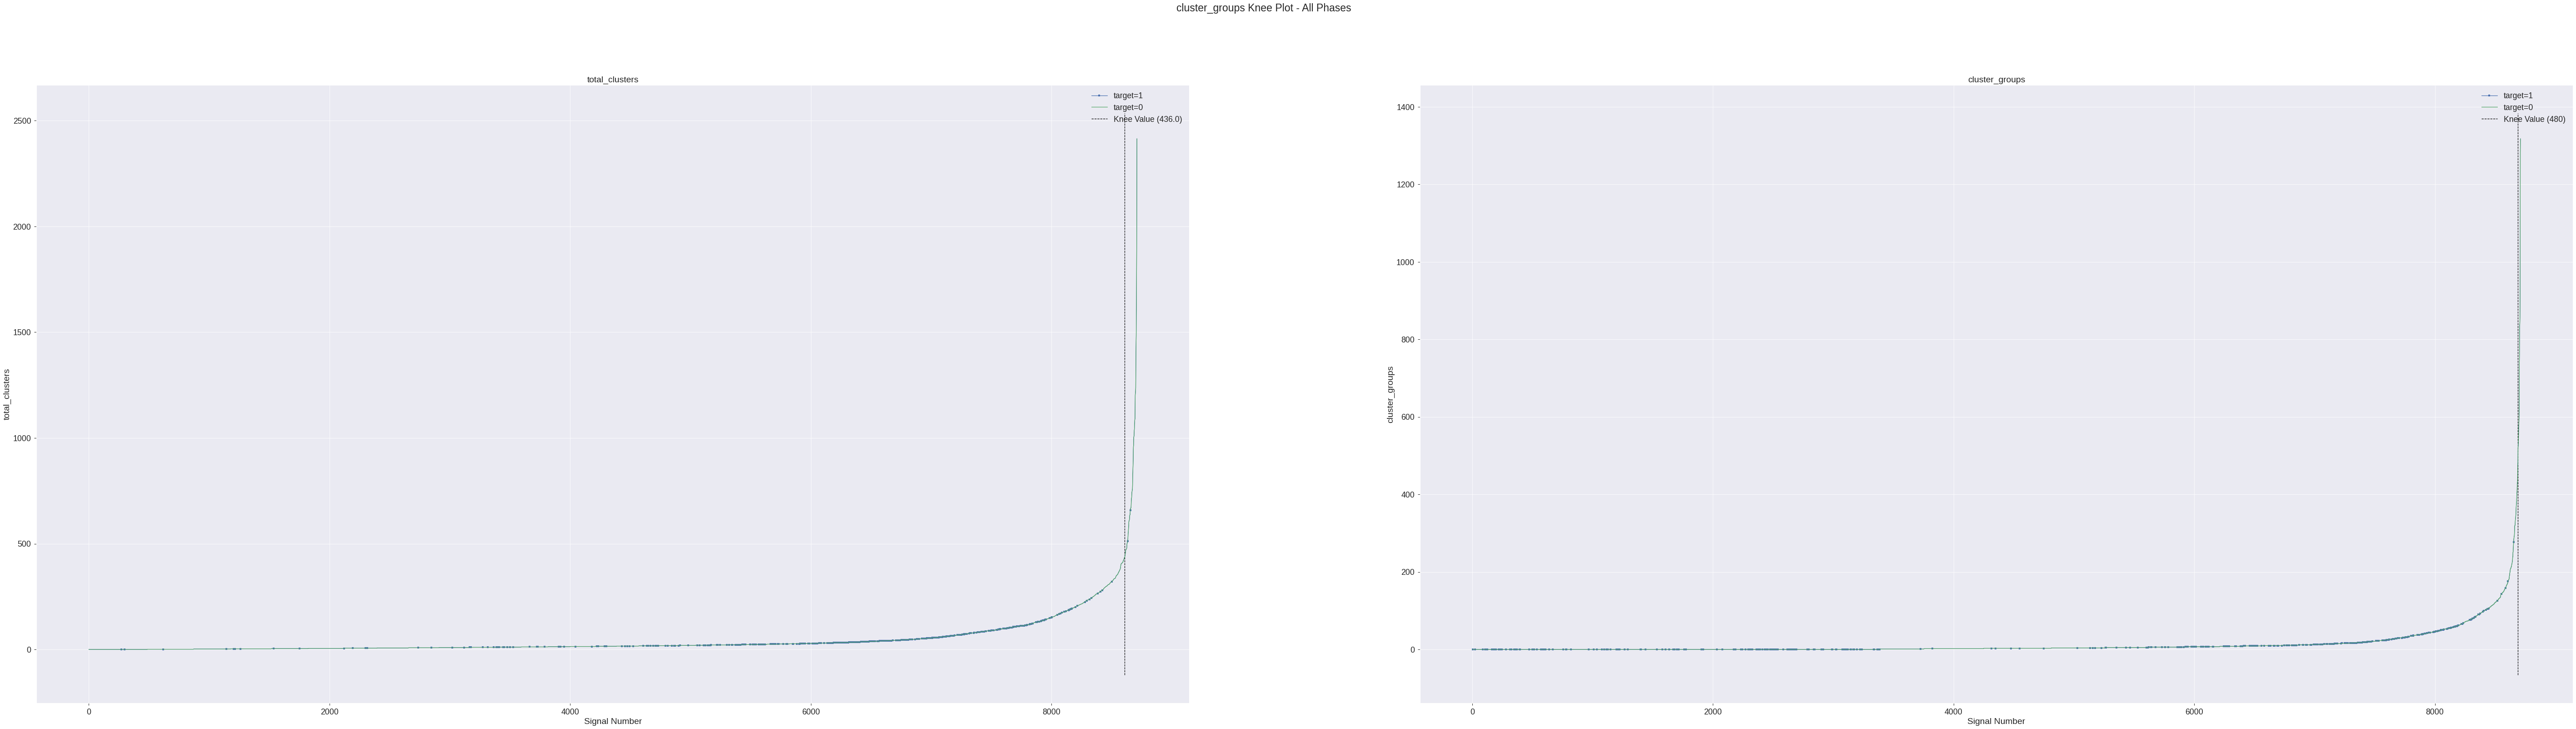

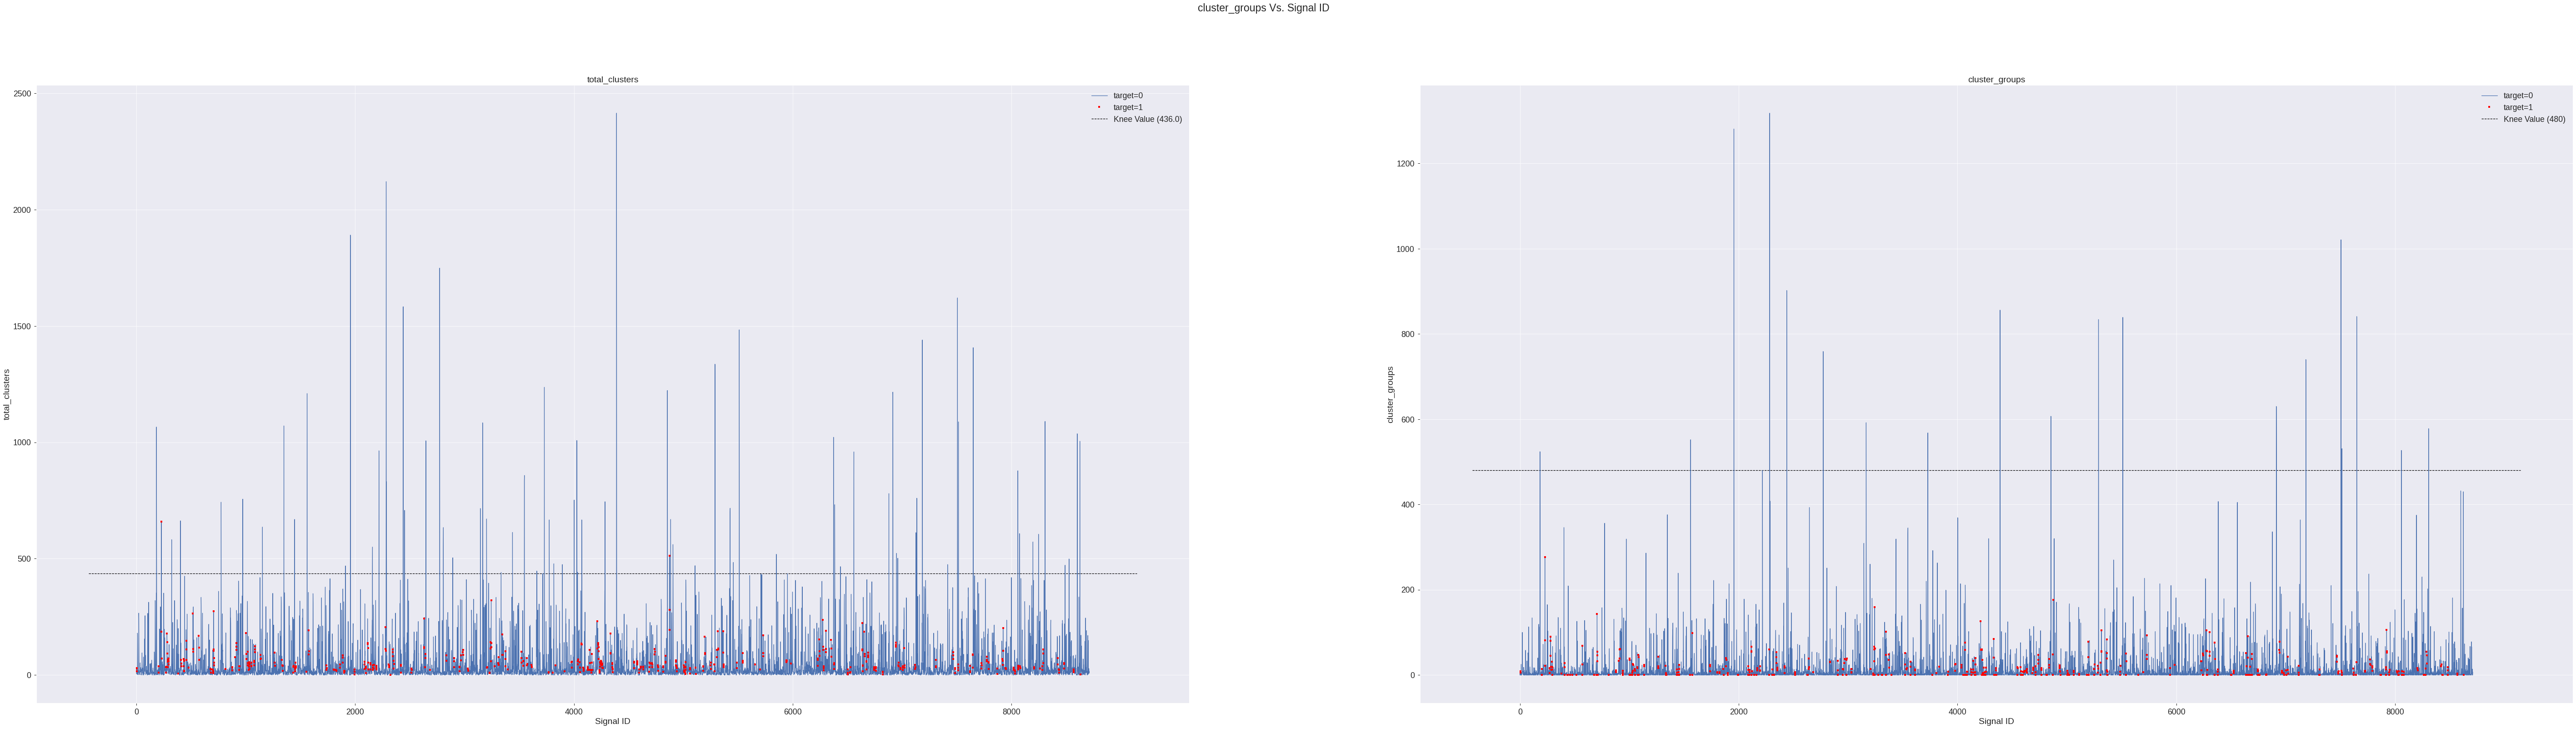

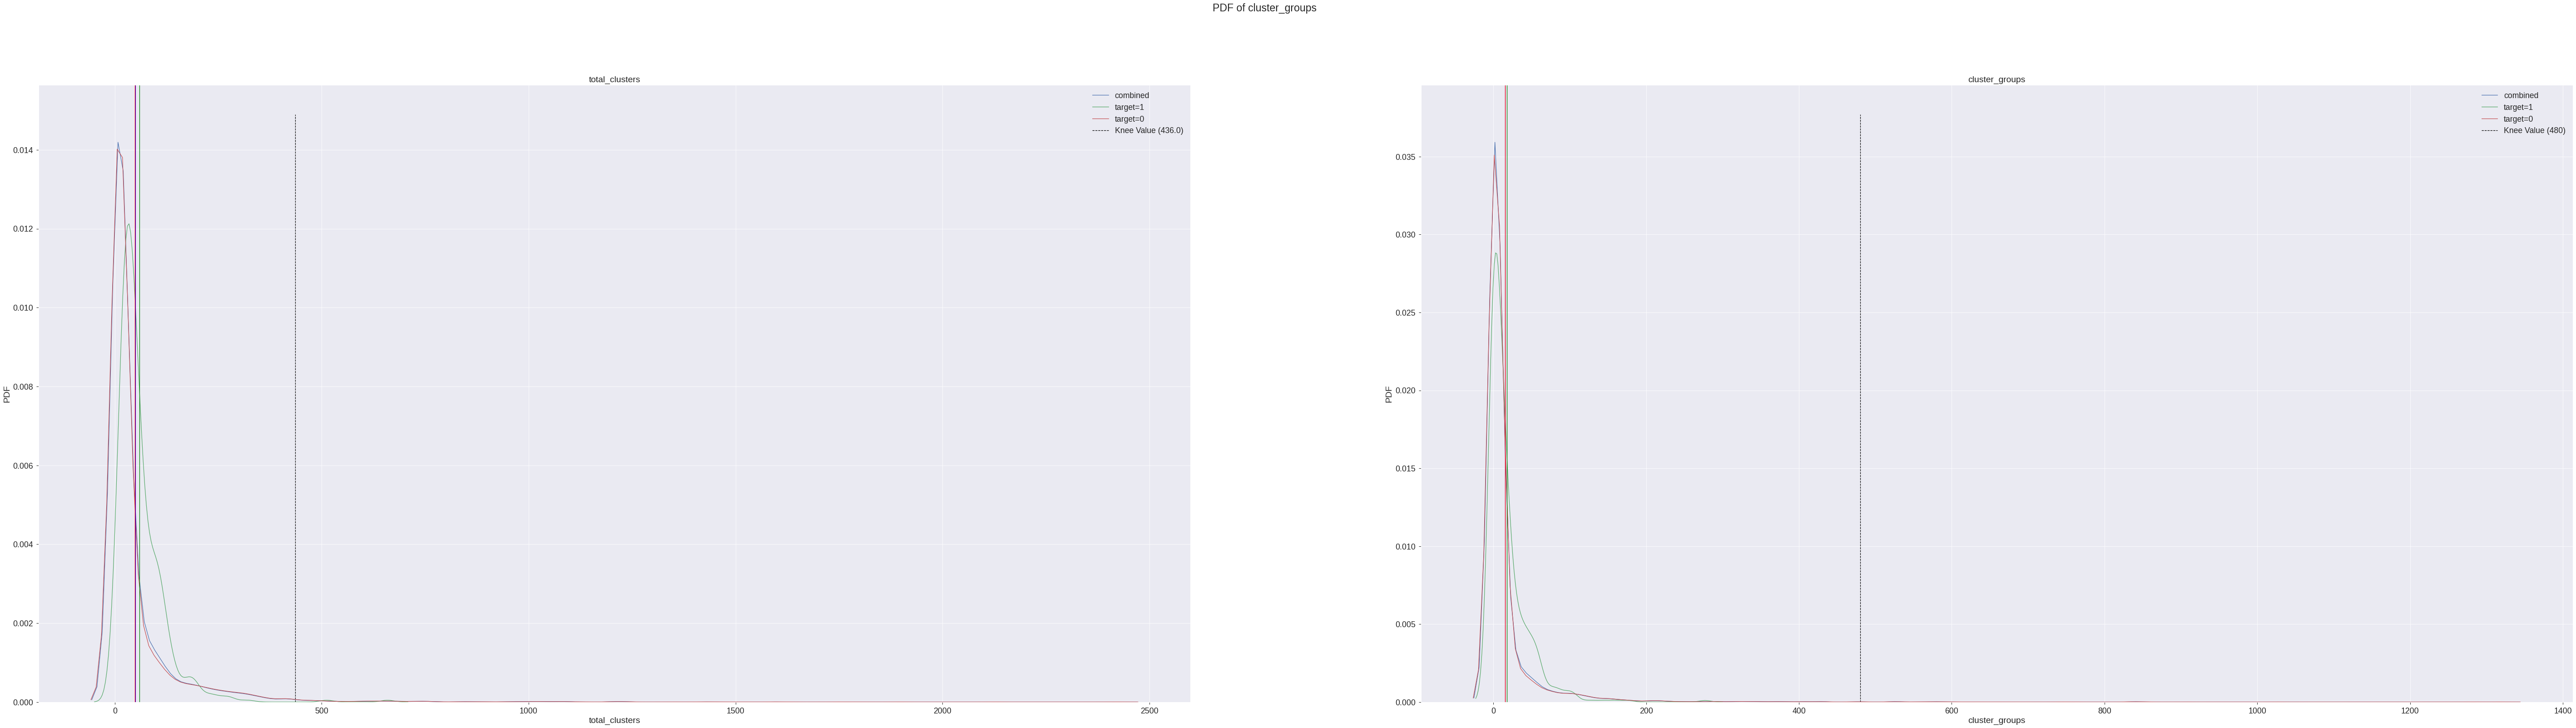

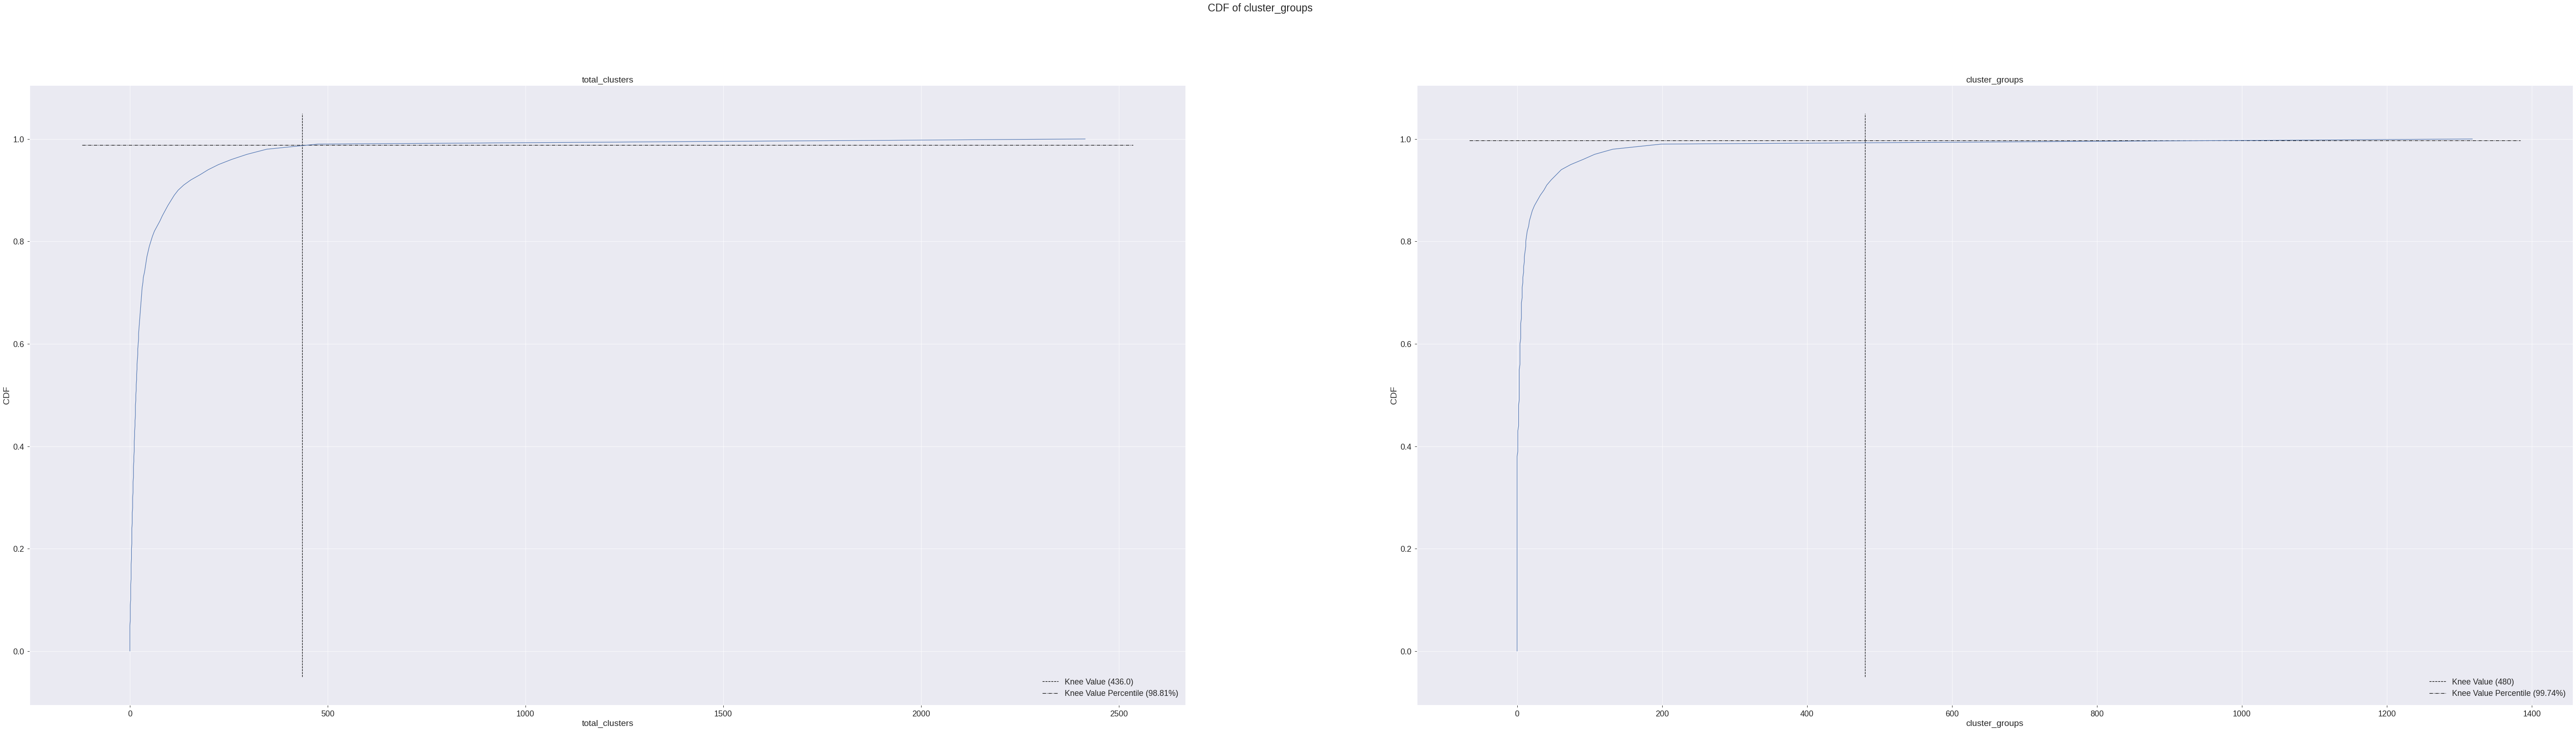

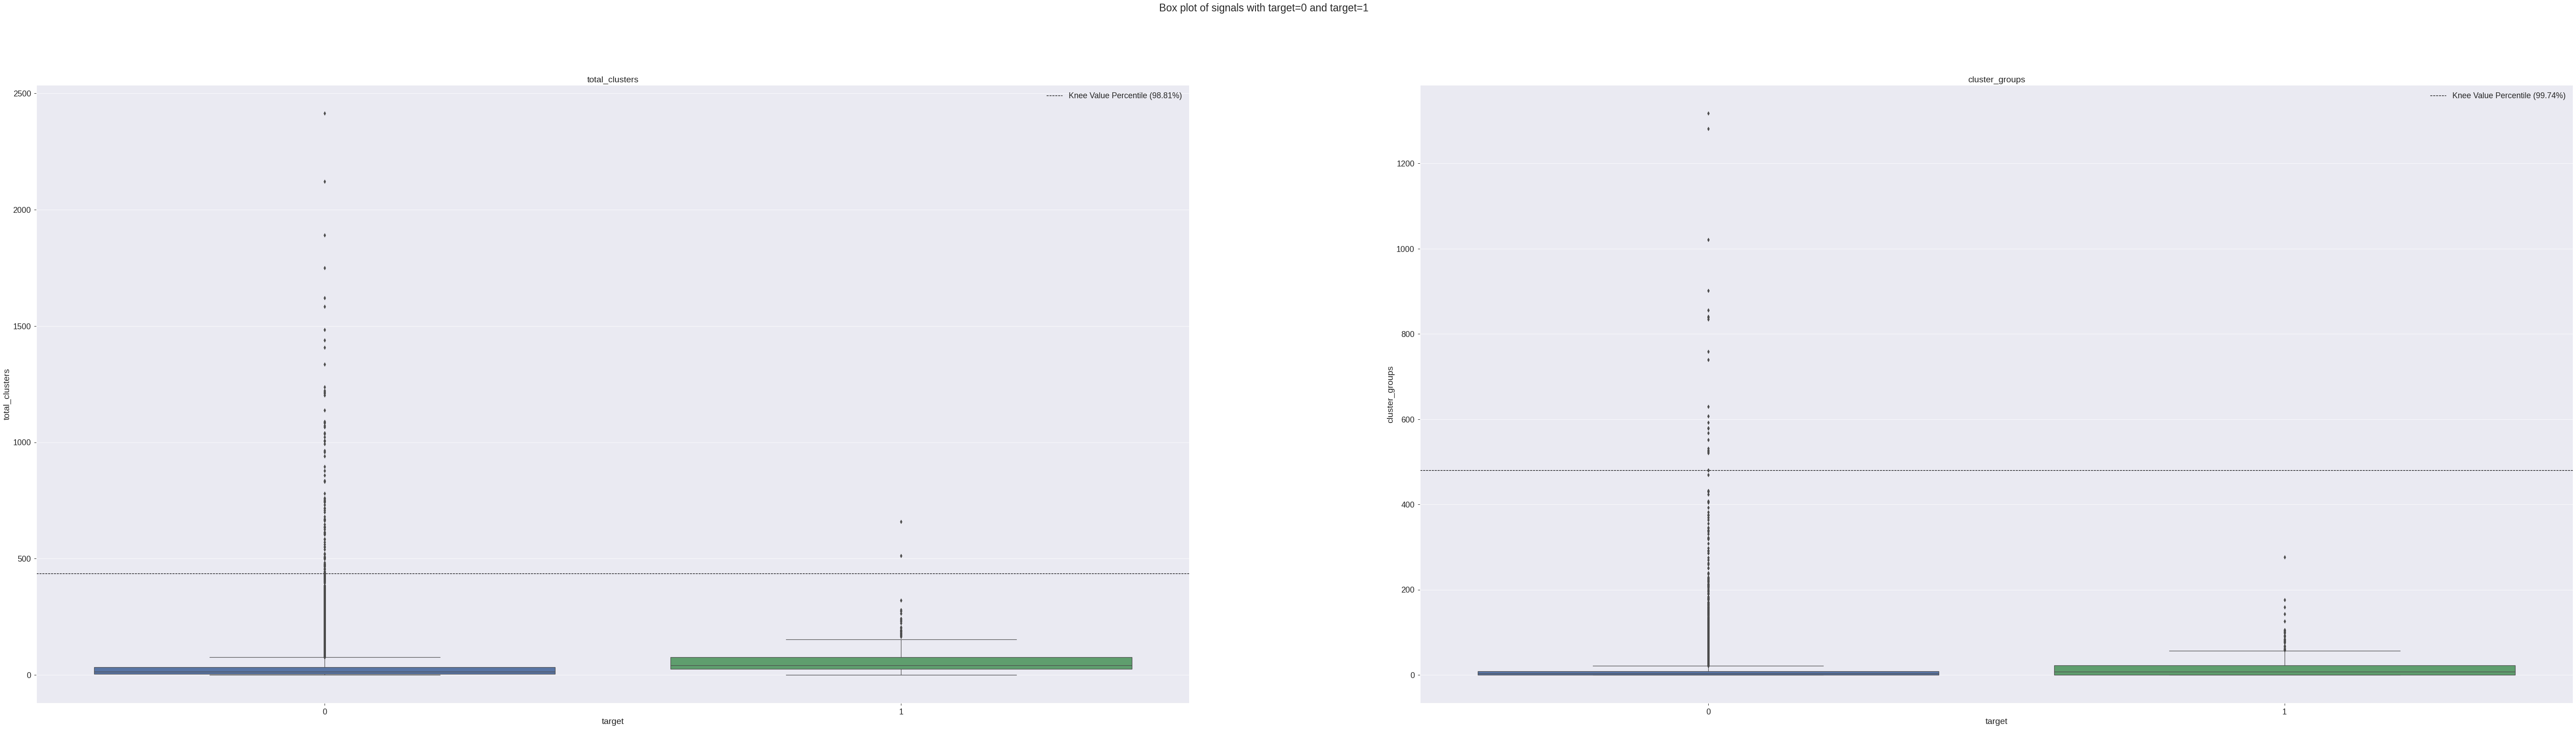

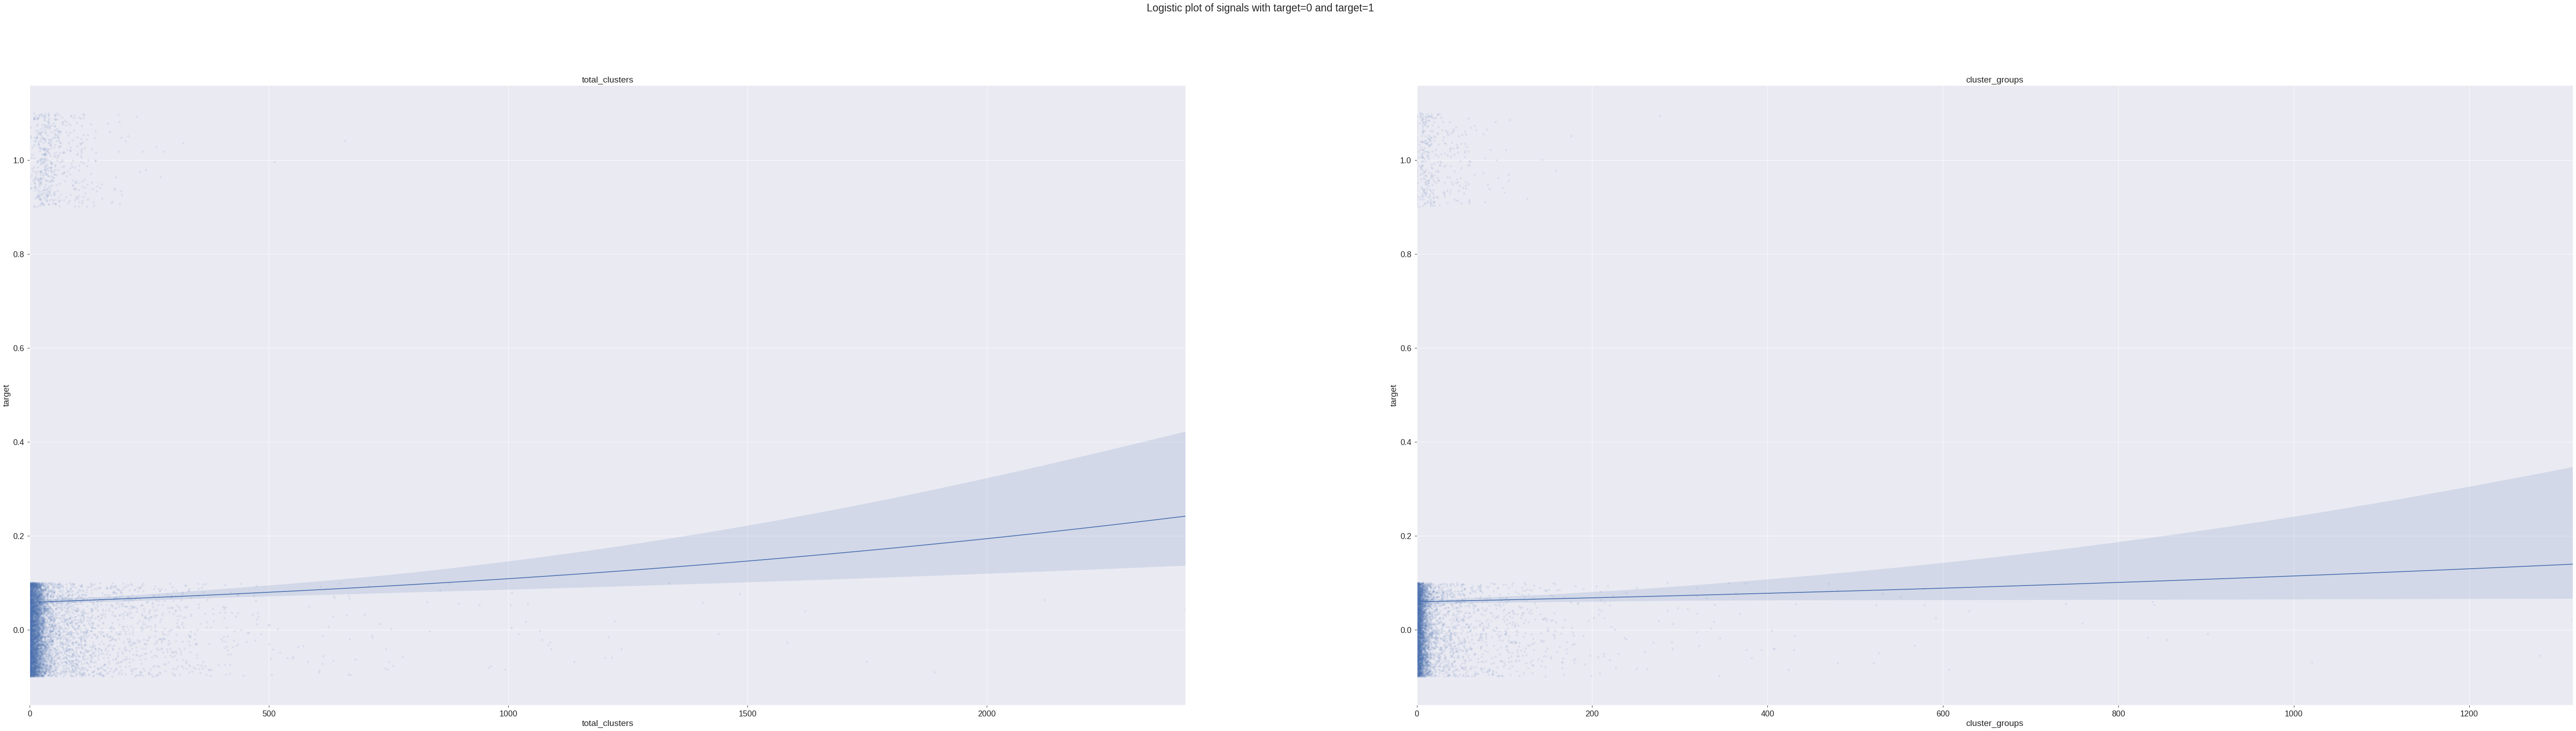

In [ ]:
peak_cluster_feats_df = pd.read_csv(path + f'peak_cluster_feats_75_train.csv')
peak_cluster_feats_df.drop(['Unnamed: 0'], axis=1, inplace=True)
peak_cluster_feats_df = pd.concat([metadata_train, peak_cluster_feats_df], axis=1)

plot_multi_compare(['total_clusters', 'cluster_groups'], 'one_phase', plt_list, peak_cluster_feats_df)

Observations:
*  Majority of the data points have total number of clusters less than 436 clusters (which is 0.0545% of all the points in the signal).
*  Total number of cluster groups of most of the signals are less than 200.
*  Separation of IQRs of signals with target=1 and target=0 is not possible.
*  Linear separability of the signal with target=1 and target=0.

##### Parameter Selection

In [ ]:
percentiles = [10, 25, 50, 75]

# Parameters to tune for XGBoost model
params = {'n_estimators': [10, 50, 100, 500, 1000], 
          'max_depth': [2, 3, 4, 5, 6],
          'learning_rate': [1e-2, 1e-1, 0.5, 0.9],
          'reg_alpha': [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2], 
          'reg_lambda': [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]}

# Create a custom (MCC) metric for evaluation of the model performance while 
# hyperparameter tuning the XGBoost model
mcc = make_scorer(matthews_corrcoef, greater_is_better=True)
best_cv_scores = []

for perc in percentiles:
  read_file_path = path + f'peak_cluster_feats_{perc}_train.csv'
  peak_cluster_feats_df = pd.read_csv(read_file_path)
  peak_cluster_feats_df.drop(['Unnamed: 0'], axis=1, inplace=True)

  # Create an XGBoost classifier object with log-loss as the loss function to minimize
  xgb_clf = xgb.XGBClassifier(random_state=42)

  x = peak_cluster_feats_df.copy()
  y = metadata_train['target'].values

  # Perform stratified 5-fold cross validation
  rand_clf = RandomizedSearchCV(xgb_clf, param_distributions=params, scoring=mcc, 
                                cv=5, random_state=42, return_train_score=True,
                                n_jobs=-1)

  # Fit the model
  rand_clf.fit(x, y)
  best_cv_scores.append(rand_clf.best_score_)
  print(f"Best CV score for {perc} percentile: {best_cv_scores[-1]}")

Best CV score for 10 percentile: 0.13815058068903613
Best CV score for 25 percentile: 0.11919250524449321
Best CV score for 50 percentile: 0.15164606888670504
Best CV score for 75 percentile: 0.10576137766651725


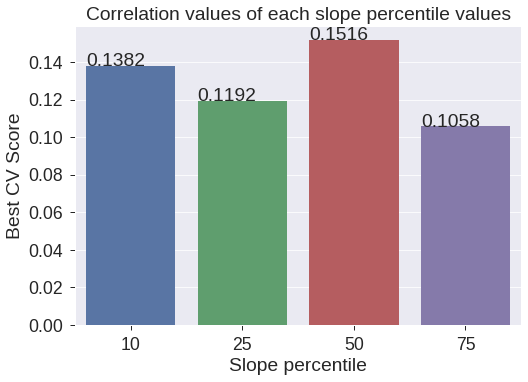

In [ ]:
splot = sns.barplot(x=perc_str, y=best_cv_scores)

# https://github.com/mwaskom/seaborn/issues/1582
for ind, p in enumerate(splot.patches):
  print_score = np.round(best_cv_scores[ind], 4)
  splot.annotate(str(print_score), (p.get_x(), p.get_height()))
plt.title("Correlation values of each slope percentile values")
plt.xlabel("Slope percentile")
plt.ylabel("Best CV Score")
plt.show()

Considering 50th percentile (median) of the difference between the consecutive indices where true peaks are observed gives the best correlation among the other percentile values. 

Hence select 50th percentile value for clustering.

In [ ]:
np.save(path+'best_cluster_slope_percentile.npy', 50)

#### Test data

In [ ]:
save_file_path = path + 'test_path/peak_cluster_test.csv'

if not os.path.isfile(save_file_path):
  start_time = datetime.now()
  print(f"Start time: {datetime.now()-start_time}")

  parallel_proc_func(get_peak_index, 'None', metadata_test.shape[0], metadata_test['signal_id'].loc[0], 
                     save_file_path, ('test'))
  print(f"Time taken: {datetime.now()-start_time}")

peak_cluster_df = pd.read_csv(save_file_path)
peak_cluster_df.drop(['Unnamed: 0'], axis=1, inplace=True)

print(peak_cluster_df.shape)
peak_cluster_df.head()

(20337, 15931)


0         1         2         3  ...  15927  15928  15929  15930
0       3.0     310.0     318.0     324.0  ...    NaN    NaN    NaN    NaN
1      10.0     314.0     322.0     327.0  ...    NaN    NaN    NaN    NaN
2     624.0    6282.0    6285.0   11180.0  ...    NaN    NaN    NaN    NaN
3     362.0       NaN       NaN       NaN  ...    NaN    NaN    NaN    NaN
4  192911.0  202031.0  210007.0  210759.0  ...    NaN    NaN    NaN    NaN

[5 rows x 15931 columns]

In [ ]:
perc = np.load(path + 'temp_files/best_cluster_slope_percentile.npy')
save_file_path = path + f'test_path/peak_clustered_{perc}_test.csv'

if not os.path.isfile(save_file_path):
  start_time = datetime.now()
  print(f"Start time: {start_time}")
  
  parallel_proc_func(get_clusters, 'None', metadata_test.shape[0], 0, 
                     save_file_path, (perc))
    
  print(f"Time taken: {datetime.now()-start_time}")

peak_cluster_group = pd.read_csv(save_file_path)
peak_cluster_group.drop(['Unnamed: 0'], axis=1, inplace=True)

print(peak_cluster_group.shape)
peak_cluster_group.head()

(10160, 15931)


0    1    2    3    4    5  ...  15925  15926  15927  15928  15929  15930
0  0.0  0.0  0.0  0.0  0.0  0.0  ...    NaN    NaN    NaN    NaN    NaN    NaN
1  0.0  0.0  0.0  0.0  0.0  0.0  ...    NaN    NaN    NaN    NaN    NaN    NaN
2  0.0  1.0  1.0  2.0  3.0  4.0  ...    NaN    NaN    NaN    NaN    NaN    NaN
3  0.0  NaN  NaN  NaN  NaN  NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN
4  0.0  1.0  2.0  2.0  2.0  3.0  ...    NaN    NaN    NaN    NaN    NaN    NaN

[5 rows x 15931 columns]

In [ ]:
perc = np.load(path + 'temp_files/best_cluster_slope_percentile.npy')
save_file_path = path + f'test_path/peak_cluster_feats_{perc}_test.csv'
cluster_cols = ['total_clusters', 'cluster_groups']

if not os.path.isfile(save_file_path):
  start_time = datetime.now()
  print(f"Start time: {start_time}")
  
  parallel_proc_func(get_cluster_groups, cluster_cols, metadata_test.shape[0], 0, 
                     save_file_path)
    
  print(f"Time taken: {datetime.now()-start_time}")

peak_cluster_group = pd.read_csv(save_file_path)
peak_cluster_group.drop(['Unnamed: 0'], axis=1, inplace=True)

print(peak_cluster_group.shape)
peak_cluster_group.head()

(20337, 2)


total_clusters  cluster_groups
0            68.0              12
1            29.0               2
2            60.0               0
3             0.0               0
4            53.0               0

### Phase features

#### Train data

In [ ]:
save_file_path = path + f'temp_files/phase_train.csv'

if not os.path.isfile(save_file_path):
  # One-hot encoding of the phase of the signal
  ohe = OneHotEncoder(sparse=False)
  ohe.fit(metadata_train['phase'].values.reshape(-1,1))
  phase_arr = ohe.transform(metadata_train['phase'].values.reshape(-1,1))
  phase_cols = ['p0', 'p1', 'p2']
  phase_arr_df = pd.DataFrame(data=phase_arr, columns=phase_cols)
  phase_arr_df.to_csv(save_file_path)
else:
  phase_arr_df = pd.read_csv(save_file_path)
  phase_arr_df.drop(['Unnamed: 0'], axis=1, inplace=True)

print(phase_arr_df.shape)
phase_arr_df.head()

(8712, 3)


p0   p1   p2
0  1.0  0.0  0.0
1  0.0  1.0  0.0
2  0.0  0.0  1.0
3  1.0  0.0  0.0
4  0.0  1.0  0.0

#### Test data

In [ ]:
save_file_path = path + f'test_path/phase_test.csv'

if not os.path.isfile(save_file_path):  
  # One-hot encoding of the phase of the signal
  ohe = OneHotEncoder(sparse=False)
  ohe.fit(metadata_test['phase'].values.reshape(-1,1))
  phase_arr = ohe.transform(metadata_test['phase'].values.reshape(-1,1))
  phase_cols = ['p0', 'p1', 'p2']
  phase_arr_df_test = pd.DataFrame(data=phase_arr, columns=phase_cols)
  phase_arr_df_test.to_csv(save_file_path)
else:
  phase_arr_df_test = pd.read_csv(save_file_path)
  phase_arr_df_test.drop(['Unnamed: 0'], axis=1, inplace=True)

print(phase_arr_df_test.shape)
phase_arr_df_test.head()

(20337, 3)


p0   p1   p2
0  1.0  0.0  0.0
1  0.0  1.0  0.0
2  0.0  0.0  1.0
3  1.0  0.0  0.0
4  0.0  1.0  0.0

In [ ]:
# Create a custom (MCC) metric for evaluation of the model performance while 
# hyperparameter tuning the XGBoost model
mcc = make_scorer(matthews_corrcoef, greater_is_better=True)
y = metadata_train['target'].values

train_funcs = [logistic_imbalanced, logistic_balanced, 
               random_forest_imbalanced, random_forest_balanced,
               lgbm_imbalanced, lgbm_balanced, xgb_imbalanced]
best_score_arr_all = []

dataset_funcs = [load_statistical_feats, load_peak_feats, load_phase_resolved_feats,
                 load_fractal_feats, load_entropy_feats, load_cluster_feats,
                 load_phase_feats]

start = datetime.now()
print(f"Start time: {start}")

for load_data in dataset_funcs:
  print(load_data.__name__)
  all_feats_df = pd.DataFrame()
  all_feats_df = load_data(all_feats_df)
  x = all_feats_df.copy()
  best_score_arr = []
  for func in train_funcs:
    start_batch = datetime.now()
    best_score = func(x, y)
    best_score_arr.append(best_score)
    print(f"{func.__name__} - Best CV score: {best_score}. Time taken: {datetime.now()-start_batch}")
  print(" ")
  best_score_arr_all.append(best_score_arr)

print(f"Total time taken: {datetime.now()-start}")

Start time: 2020-11-21 11:35:08.779014
load_statistical_feats
logistic_imbalanced - Best CV score: 0.18033863140105683. Time taken: 0:05:53.838965
logistic_balanced - Best CV score: 0.4569950107997404. Time taken: 0:06:06.666121
random_forest_imbalanced - Best CV score: 0.26916598836409483. Time taken: 0:02:12.799224
random_forest_balanced - Best CV score: 0.4153498345641612. Time taken: 0:02:01.908009
lgbm_imbalanced - Best CV score: 0.5484982245480037. Time taken: 0:00:13.627518
lgbm_balanced - Best CV score: 0.5874412775197996. Time taken: 0:00:17.951950
xgb_imbalanced - Best CV score: 0.5851484354927514. Time taken: 0:01:49.317975
 
load_peak_feats
logistic_imbalanced - Best CV score: -0.037857430979837736. Time taken: 0:01:47.942388
logistic_balanced - Best CV score: 0.1553776010222765. Time taken: 0:01:48.700801
random_forest_imbalanced - Best CV score: 0.45167886551081937. Time taken: 0:01:13.531800
random_forest_balanced - Best CV score: 0.4895831651636935. Time taken: 0:01:11.

In [ ]:
result_df = pd.DataFrame(data=best_score_arr_all, columns=[x.__name__ for x in train_funcs])
result_df['feature_type'] = [x.__name__[5:] for x in dataset_funcs]

# Put feature_type at the 1st position
# https://stackoverflow.com/questions/13148429/how-to-change-the-order-of-dataframe-columns
cols = result_df.columns.to_list()
cols = cols[-1:] + cols[:-1]
result_df = result_df[cols]

result_df.to_csv(path + f'temp_files/unitype_result.csv')
result_df

feature_type  logistic_imbalanced  ...  lgbm_balanced  xgb_imbalanced
0     statistical_feats             0.180339  ...       0.587441        0.585148
1            peak_feats            -0.037857  ...       0.599933        0.631663
2  phase_resolved_feats             0.000000  ...       0.546435        0.525867
3         fractal_feats             0.382640  ...       0.582014        0.548558
4         entropy_feats             0.302475  ...       0.444156        0.432586
5         cluster_feats             0.000000  ...       0.251585        0.151646
6           phase_feats             0.000000  ...       0.009208        0.000000

[7 rows x 8 columns]

Conclusions:
*  Fractal and entropy features alone are good at linearly separating the signals with target=1 and target=0.
*  Peak features are good at non-linearly separating the signals with target=1 and target=0.
*  Basic statistical features of the signal alone also prove to be quite good at classifying the signal with target=1 and target=0.
*  Cluster features alone is not that good at the classification as there is no linear correlation of the signal with the target and very less non-linear correlation of the signal with target.